<a href="https://colab.research.google.com/github/TsunadeEN/Data-Mining-/blob/main/Data%20Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Text processing libraries:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling libraries:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Download required NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load the dataset (update the path accordingly)
df = pd.read_csv("/content/Airline_review_assignment_data.csv")
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


First 5 rows of the dataset:
   ID   Airline Name Overall_Rating                           Review_Title  \
0   0    AB Aviation              9                "pretty decent airline"   
1   1    AB Aviation              1                   "Not a good airline"   
2   2    AB Aviation              1         "flight was fortunately short"   
3   3  Adria Airways              1    "I will never fly again with Adria"   
4   4  Adria Airways              1  "it ruined our last days of holidays"   

           Review Date  Verified  \
0   11th November 2019      True   
1       25th June 2019      True   
2       25th June 2019      True   
3  28th September 2019     False   
4  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an...  Embraer E120    
3

In [ ]:
df.dtypes

,0
ID,int64
Airline Name,object
Overall_Rating,object
Review_Title,object
Review Date,object
Verified,bool
Review,object
Aircraft,object
Type Of Traveller,object
Seat Type,object


# **Data Pre-Processing For Numerical Values**

In [ ]:
# 1.1 Define numerical columns
numerical_cols = [
    'Overall_Rating', 'Seat Comfort', 'Cabin Staff Service',
    'Food & Beverages', 'Ground Service', 'Inflight Entertainment',
    'Wifi & Connectivity', 'Value For Money'
]

# 1.2 Convert each numerical column to numeric.
for col in numerical_cols:
    df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')
    print(f"{col} - Converted dtype: {df[col].dtype}")

Overall_Rating - Converted dtype: object
Seat Comfort - Converted dtype: float64
Cabin Staff Service - Converted dtype: float64
Food & Beverages - Converted dtype: float64
Ground Service - Converted dtype: float64
Inflight Entertainment - Converted dtype: float64
Wifi & Connectivity - Converted dtype: float64
Value For Money - Converted dtype: float64


In [ ]:
# 1.3 Check missing values in these numerical columns.
print("\nMissing Values in Numerical Columns:")
print(df[numerical_cols].isnull().sum())


Missing Values in Numerical Columns:
Overall_Rating              842
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
dtype: int64


In [ ]:
# 1.4 Impute missing values using the median for each numerical column.
    median_val = df[col].median()
    df.loc[:, col] = df[col].fillna(median_val)
    print(f"Imputed missing values in {col} with median: {median_val}")

print("\nMissing Values After Imputation:")
print(df[numerical_cols].isnull().sum())

Imputed missing values in Overall_Rating with median: 1.0
Imputed missing values in Seat Comfort with median: 3.0
Imputed missing values in Cabin Staff Service with median: 3.0
Imputed missing values in Food & Beverages with median: 2.0
Imputed missing values in Ground Service with median: 1.0
Imputed missing values in Inflight Entertainment with median: 2.0
Imputed missing values in Wifi & Connectivity with median: 1.0
Imputed missing values in Value For Money with median: 2.0

Missing Values After Imputation:
Overall_Rating            0
Seat Comfort              0
Cabin Staff Service       0
Food & Beverages          0
Ground Service            0
Inflight Entertainment    0
Wifi & Connectivity       0
Value For Money           0
dtype: int64


<ipython-input-19-f513c04f4daa>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df[col].fillna(median_val)



Outlier Detection Results:
Overall_Rating: Lower Bound = -5.0, Upper Bound = 11.0, Outliers Detected = 0
Seat Comfort: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0
Cabin Staff Service: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0
Food & Beverages: Lower Bound = 0.5, Upper Bound = 4.5, Outliers Detected = 2494
Ground Service: Lower Bound = -2.0, Upper Bound = 6.0, Outliers Detected = 0
Inflight Entertainment: Lower Bound = 2.0, Upper Bound = 2.0, Outliers Detected = 9551
Wifi & Connectivity: Lower Bound = 1.0, Upper Bound = 1.0, Outliers Detected = 1859
Value For Money: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0


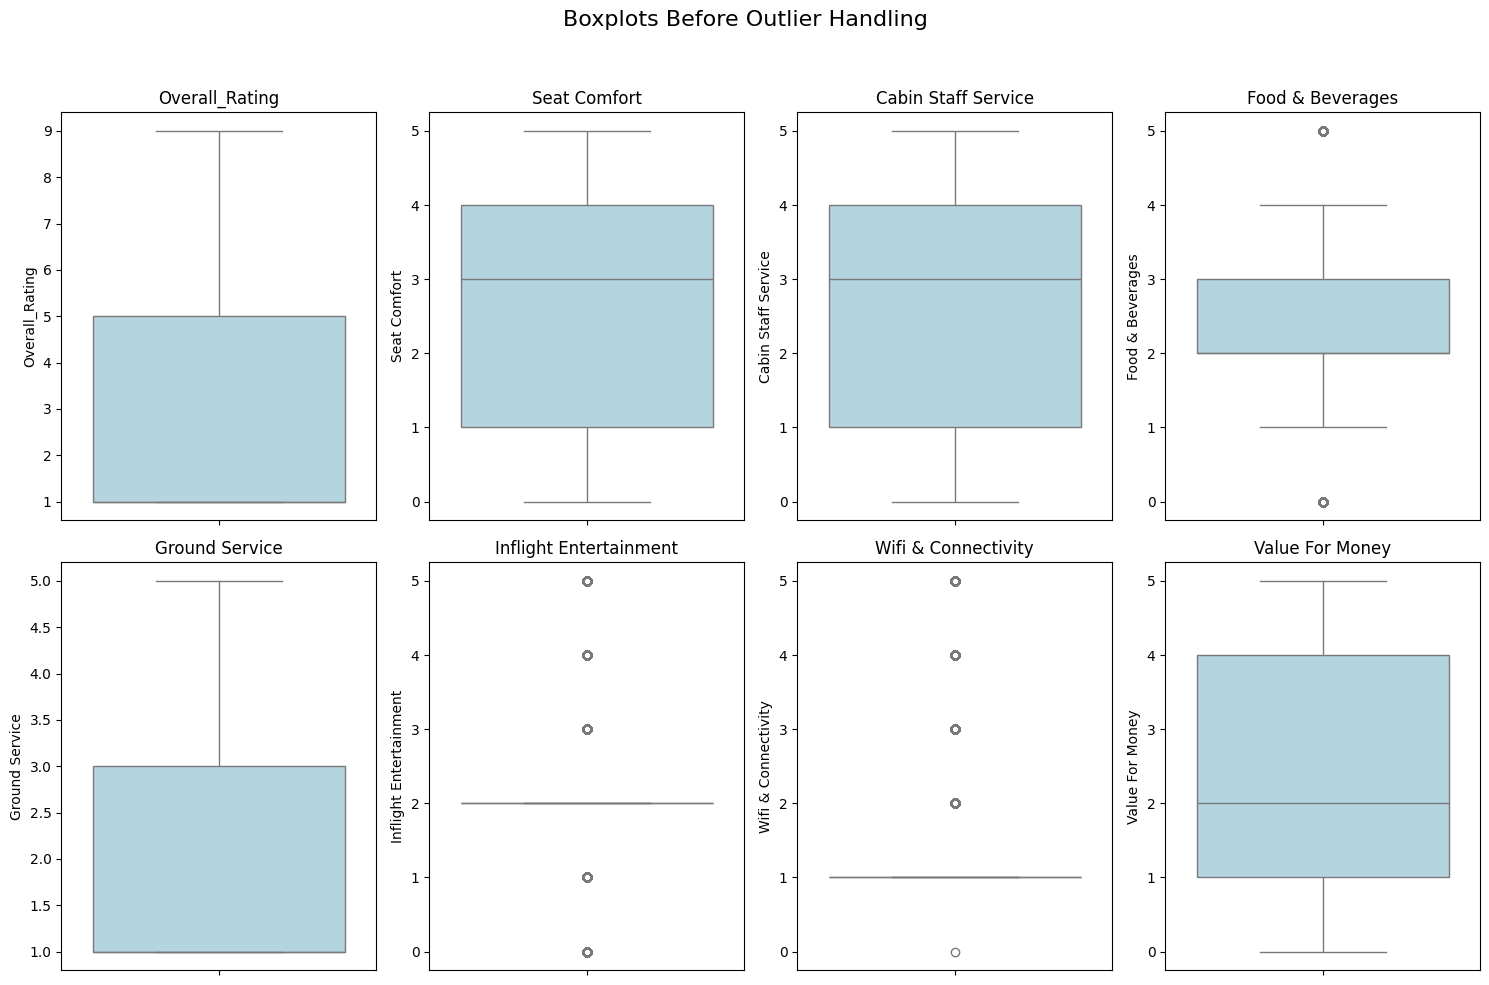

In [ ]:
# 1.5 Outlier Detection & Handling using the IQR method:
def detect_outliers_iqr(df, columns):
    """Detect outliers in each column using the IQR rule."""
    outlier_info = {}
    for col in columns:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_info[col] = {"lower_bound": lower_bound,
                             "upper_bound": upper_bound,
                             "num_outliers": len(outlier_indices)}
        print(f"{col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}, Outliers Detected = {len(outlier_indices)}")
    return outlier_info

print("\nOutlier Detection Results:")
outliers_info = detect_outliers_iqr(df, numerical_cols)

# Visualize boxplots before outlier handling.
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)
plt.suptitle("Boxplots Before Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

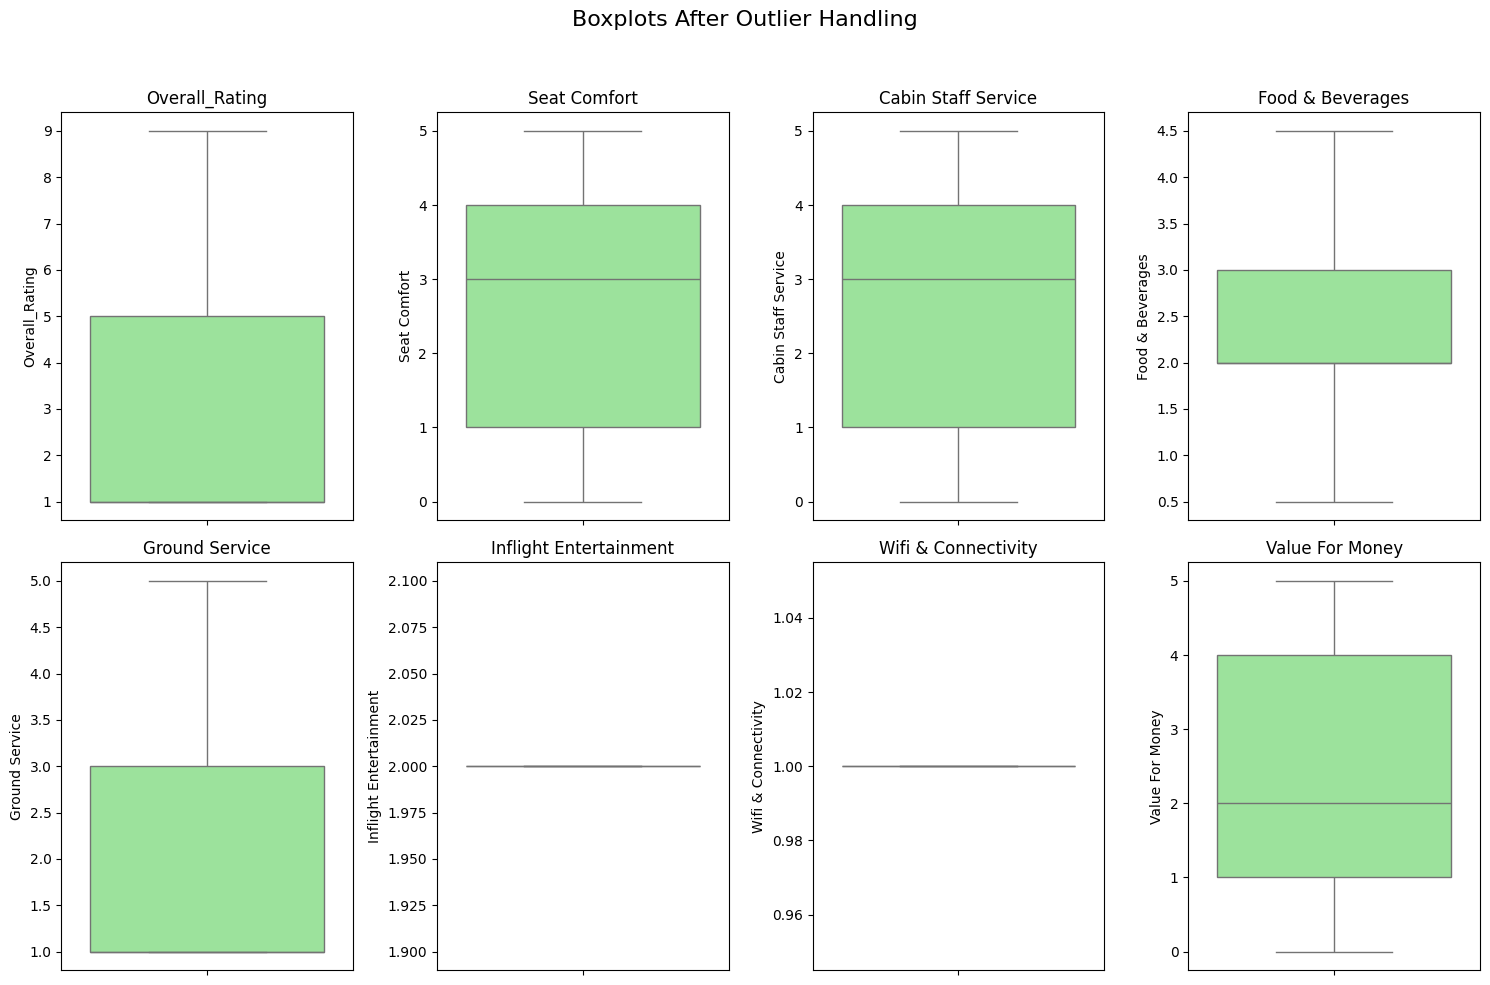

In [ ]:
# 1.6 Cap (Winsorize) the outliers.
def cap_outliers(df, col):
    """Cap the extreme values based on IQR lower and upper bounds."""
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

for col in numerical_cols:
    cap_outliers(df, col)

# Visualize boxplots after outlier handling.
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(col)
plt.suptitle("Boxplots After Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

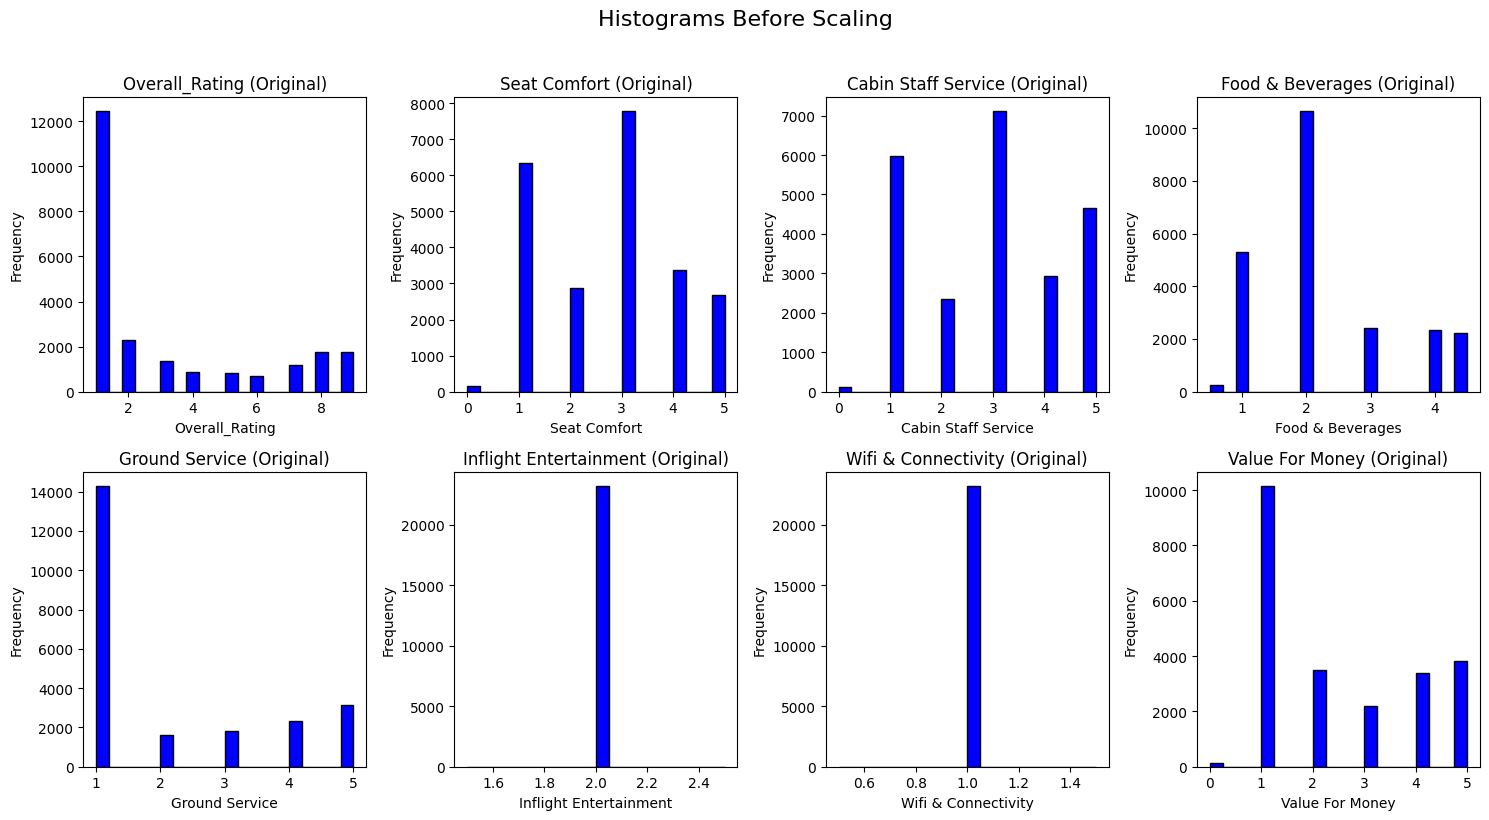

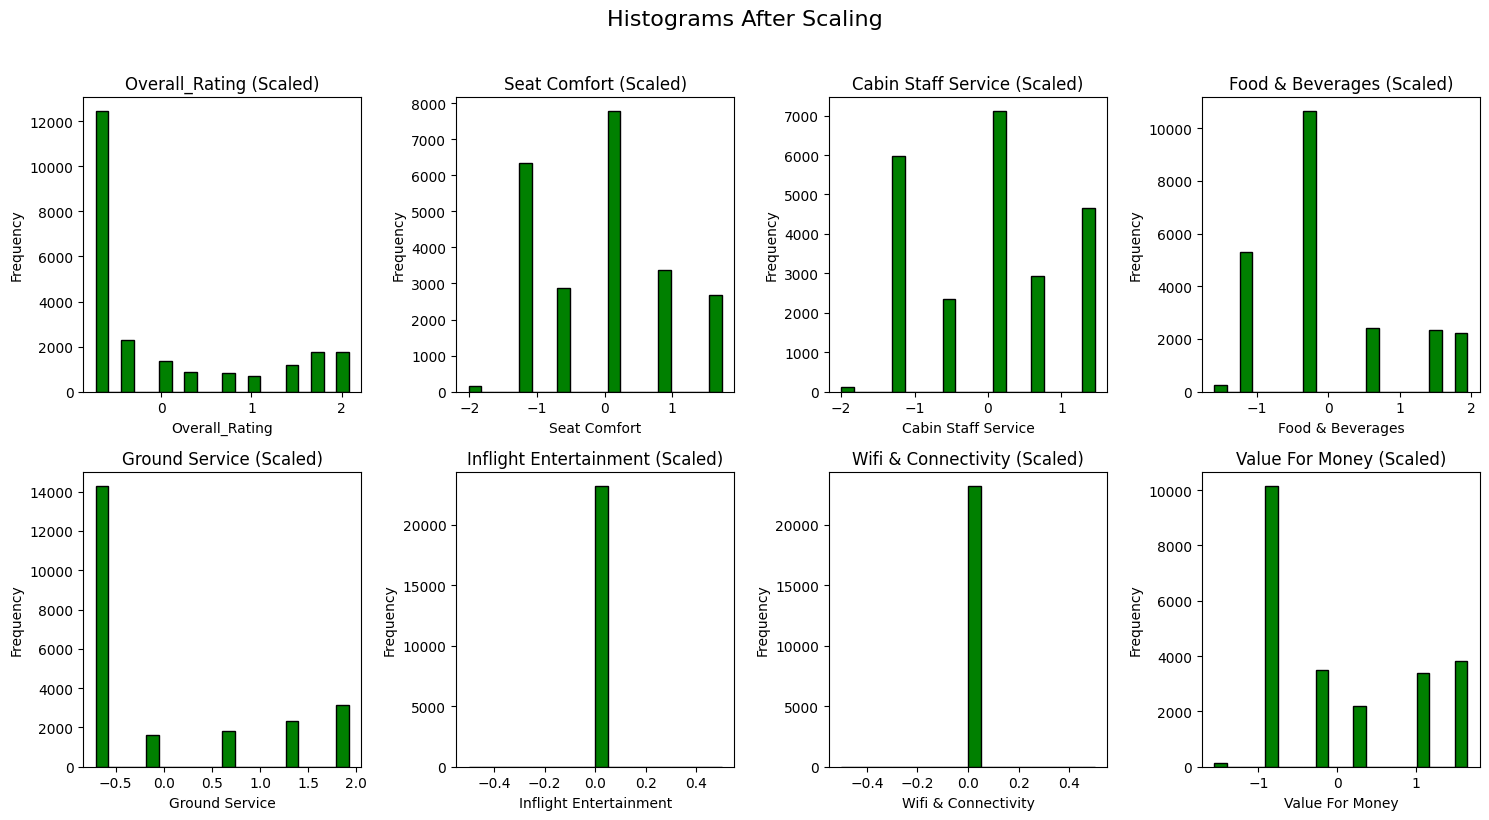

In [ ]:
# 1.7 Normalize/Scale numerical features using StandardScaler.
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# Visualize histograms before and after scaling.
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    plt.hist(df[col], bins=20, edgecolor='black', color='blue')
    plt.title(f"{col} (Original)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.suptitle("Histograms Before Scaling", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    plt.hist(df_scaled[col], bins=20, edgecolor='black', color='green')
    plt.title(f"{col} (Scaled)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.suptitle("Histograms After Scaling", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

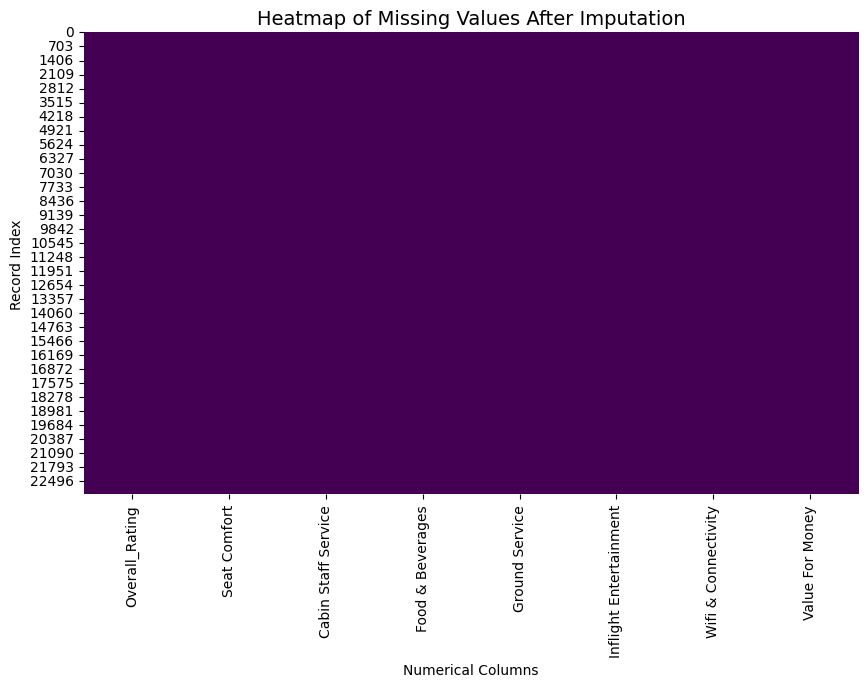

In [ ]:
# Visualize missing values after imputation using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values After Imputation", fontsize=14)
plt.xlabel("Numerical Columns")
plt.ylabel("Record Index")
plt.show()

In [ ]:
def detect_outliers_iqr(df, columns):
    outlier_info = {}
    for col in columns:
        # Calculate Q1, Q3, and IQR for the column
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        # Calculate lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_info[col] = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "num_outliers": len(outlier_indices),
            "indices": outlier_indices
        }
        print(f"{col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}, Outliers Detected = {len(outlier_indices)}")
    return outlier_info

In [ ]:
# Detect and print outliers information
outliers_info = detect_outliers_iqr(df, numerical_cols)

Overall_Rating: Lower Bound = -5.0, Upper Bound = 11.0, Outliers Detected = 0
Seat Comfort: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0
Cabin Staff Service: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0
Food & Beverages: Lower Bound = 0.5, Upper Bound = 4.5, Outliers Detected = 2494
Ground Service: Lower Bound = -2.0, Upper Bound = 6.0, Outliers Detected = 0
Inflight Entertainment: Lower Bound = 2.0, Upper Bound = 2.0, Outliers Detected = 9551
Wifi & Connectivity: Lower Bound = 1.0, Upper Bound = 1.0, Outliers Detected = 1859
Value For Money: Lower Bound = -3.5, Upper Bound = 8.5, Outliers Detected = 0


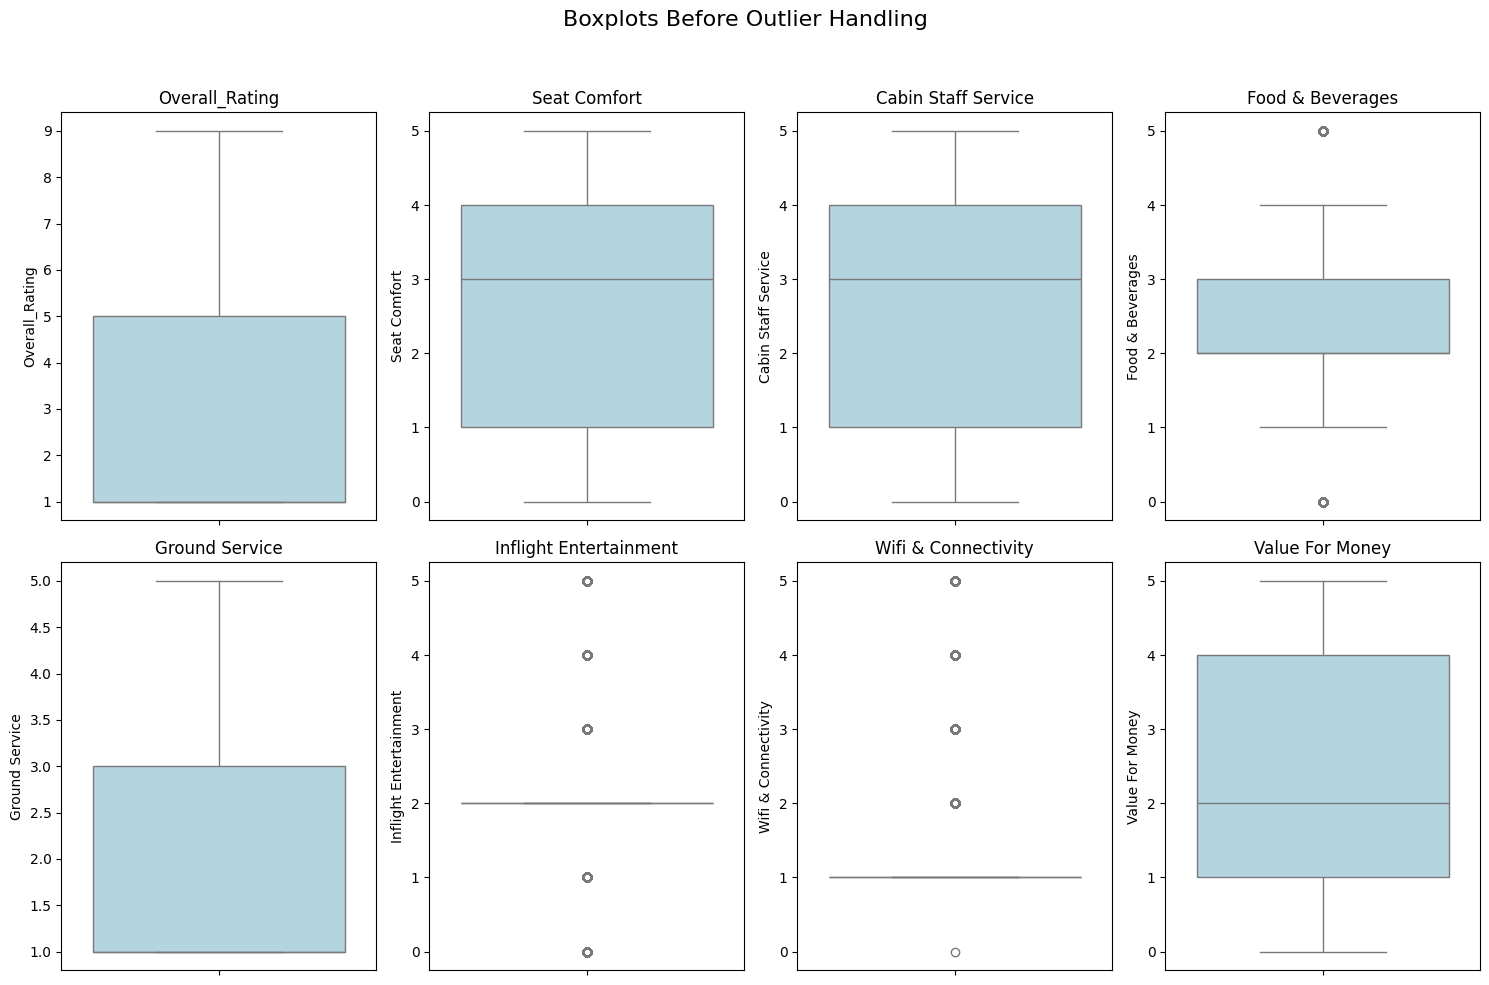

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)
    plt.xlabel('')
plt.suptitle("Boxplots Before Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def cap_outliers(df, col):
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the values below lower_bound and above upper_bound
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

# Apply outlier capping for each numerical column
for col in numerical_cols:
    cap_outliers(df, col)

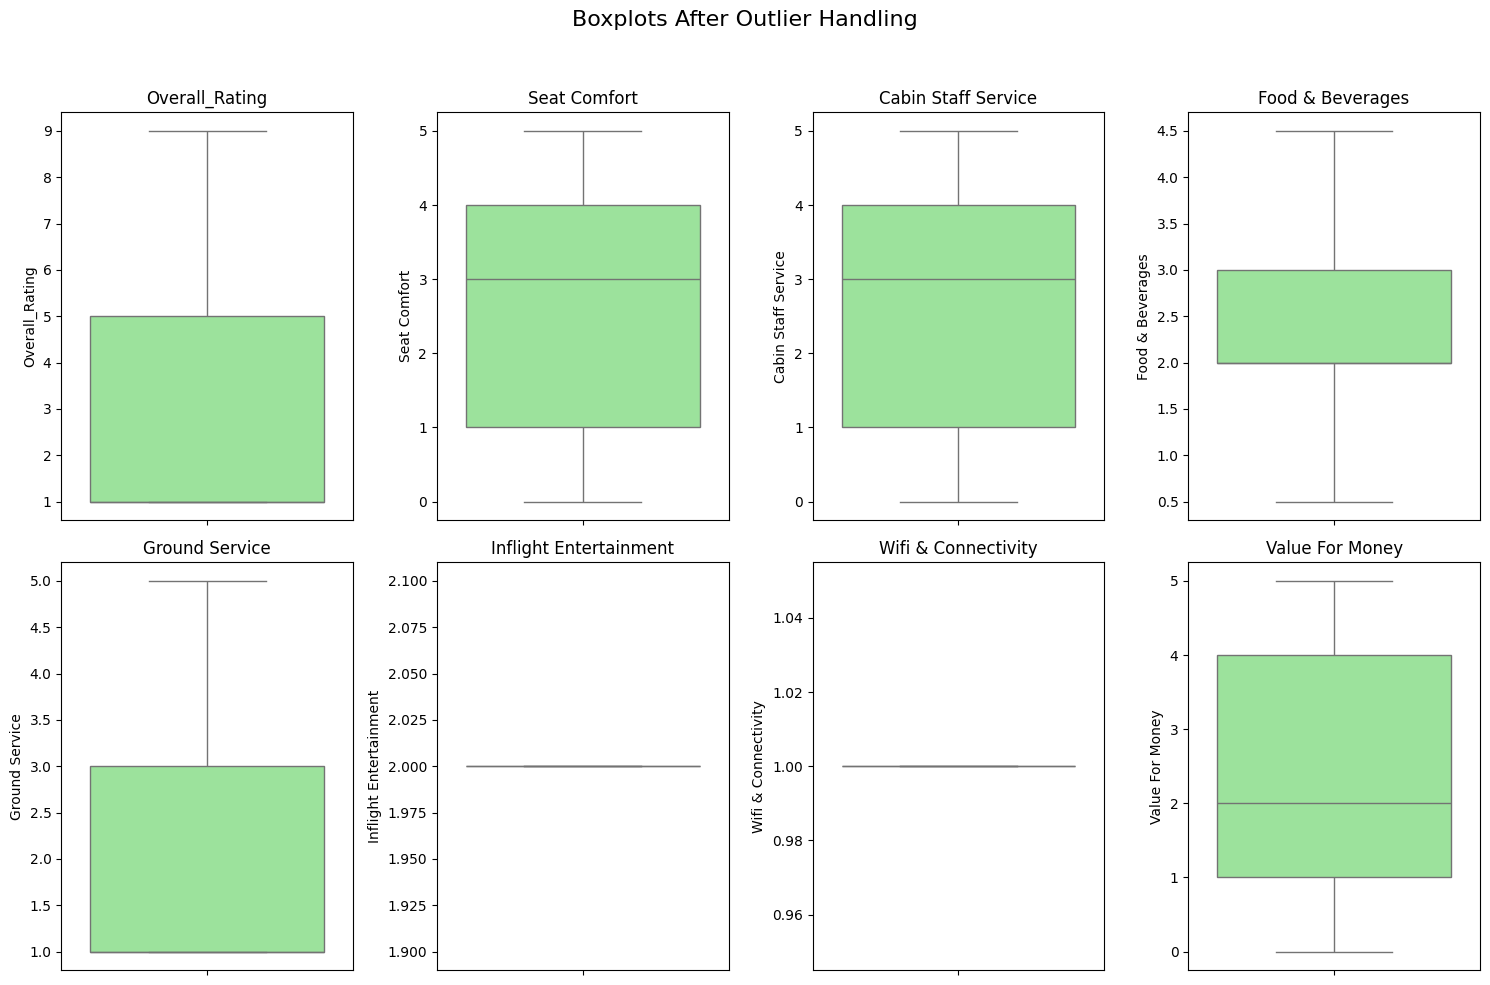

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(col)
    plt.xlabel('')
plt.suptitle("Boxplots After Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the DataFrame for scaling
df_scaled = df.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

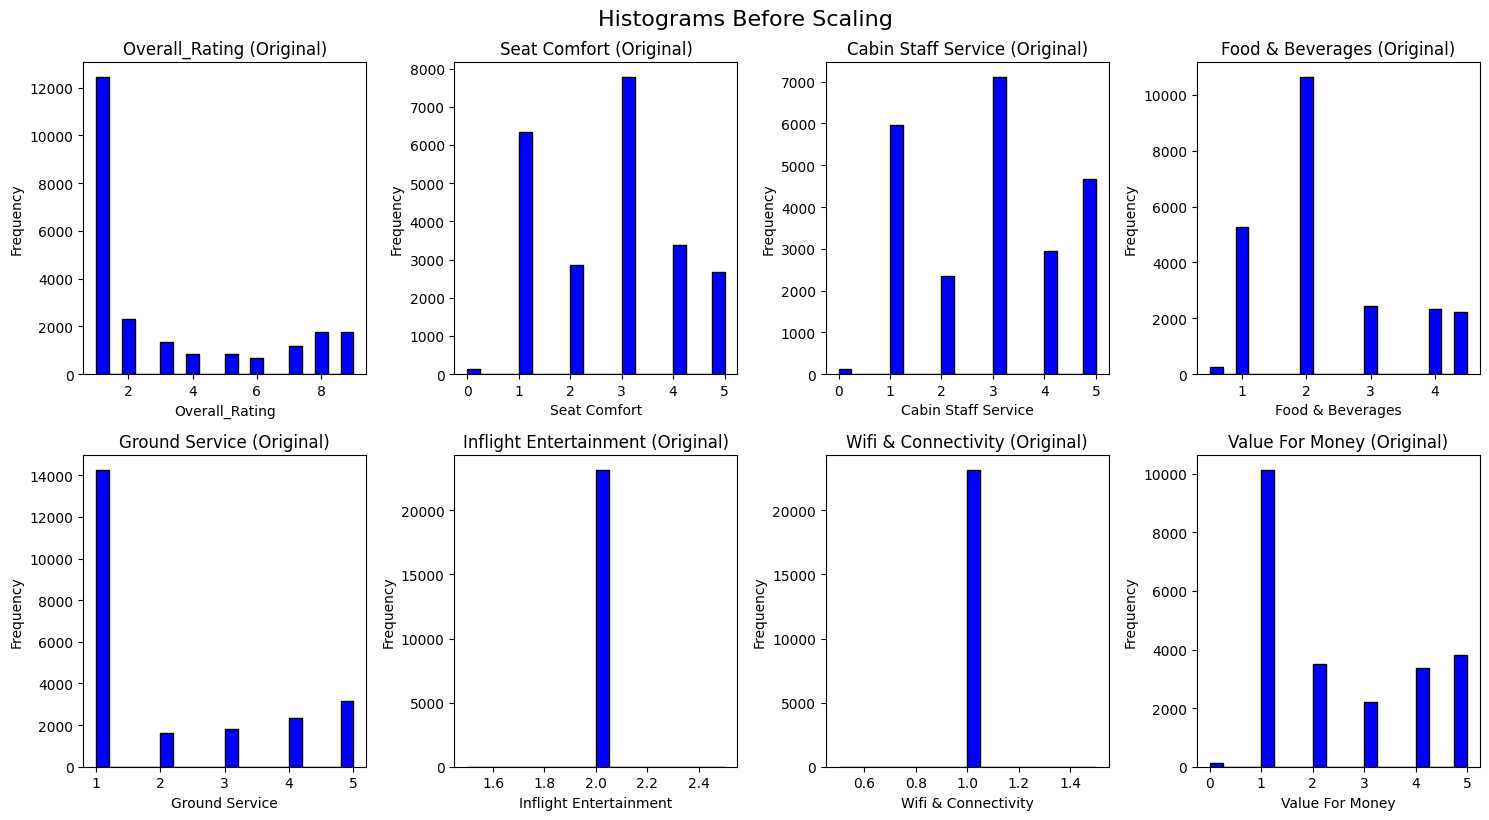

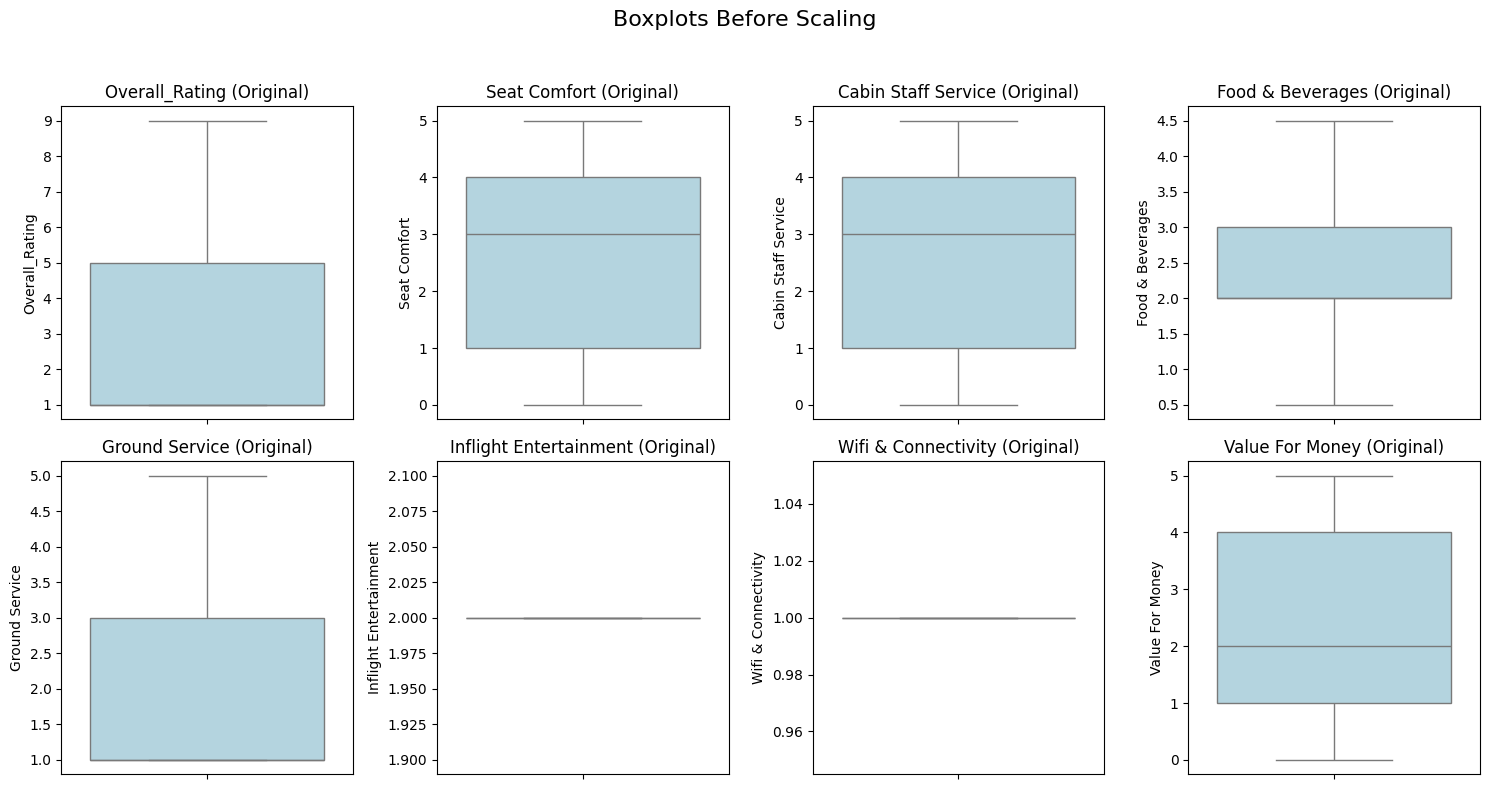

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distributions (histograms and boxplots) before scaling
plt.figure(figsize=(15, 8))

# Histograms before scaling
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    plt.hist(df[col], bins=20, edgecolor='black', color='blue')
    plt.title(f"{col} (Original)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.suptitle("Histograms Before Scaling", fontsize=16, y=1.02)
plt.show()

# Boxplots before scaling
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f"{col} (Original)")
    plt.xlabel("")
plt.suptitle("Boxplots Before Scaling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

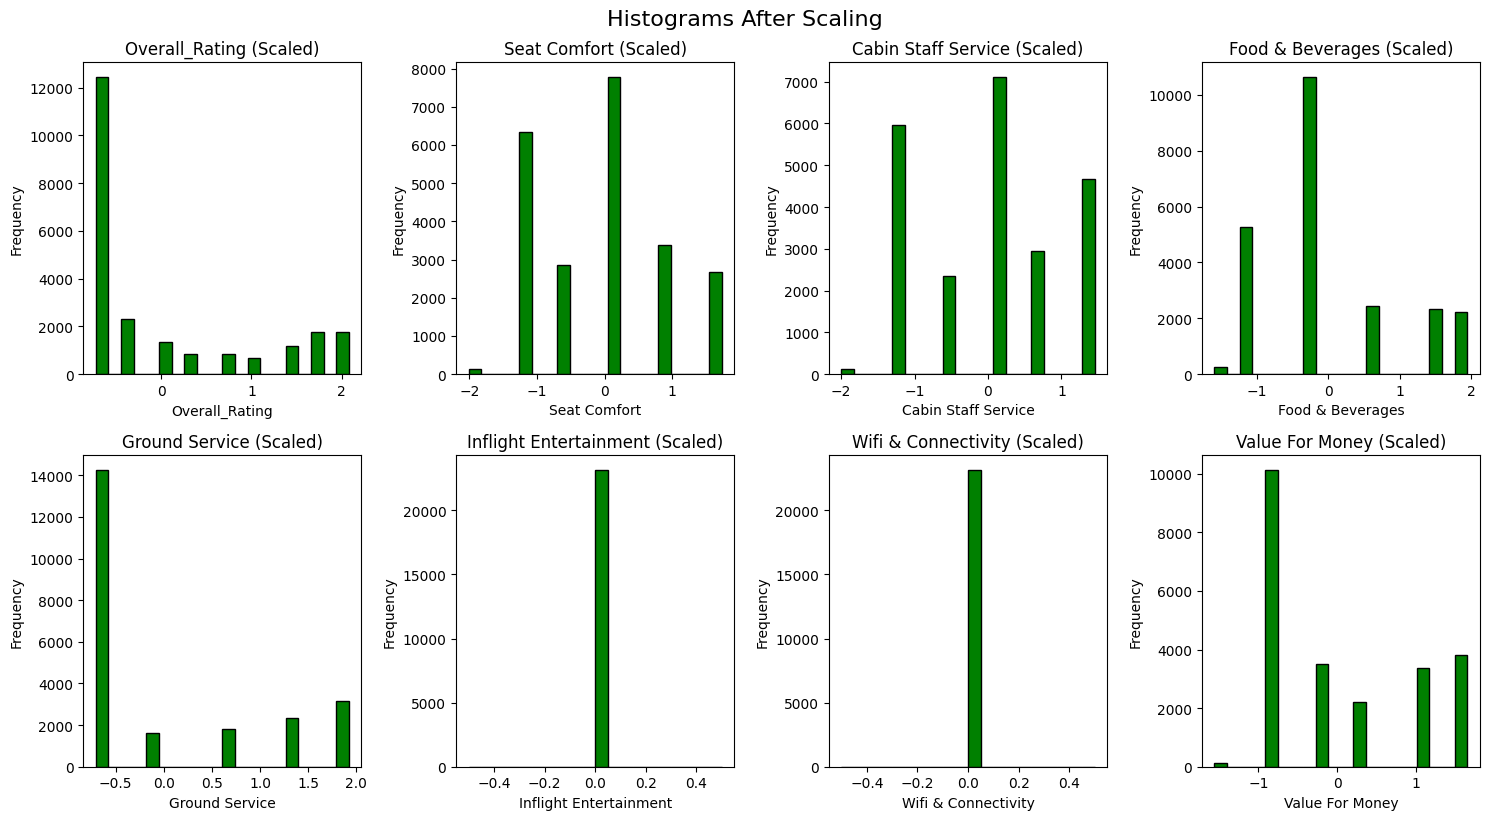

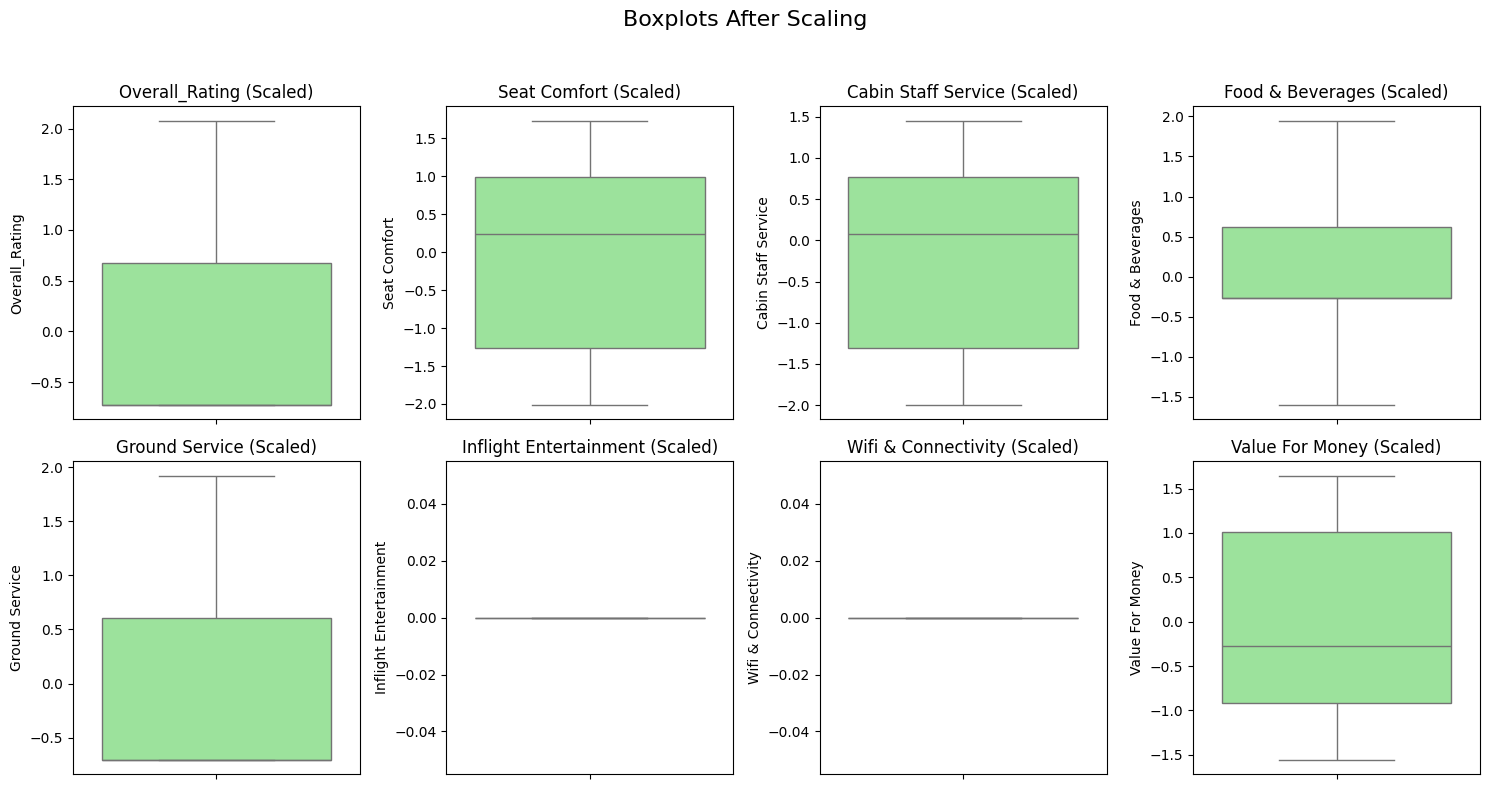

In [ ]:
# Visualize distributions (histograms and boxplots) after scaling
plt.figure(figsize=(15, 8))

# Histograms after scaling
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    plt.hist(df_scaled[col], bins=20, edgecolor='black', color='green')
    plt.title(f"{col} (Scaled)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.suptitle("Histograms After Scaling", fontsize=16, y=1.02)
plt.show()

# Boxplots after scaling
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df_scaled[col], color='lightgreen')
    plt.title(f"{col} (Scaled)")
    plt.xlabel("")
plt.suptitle("Boxplots After Scaling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Data Cleaning and Preparation

### 1. Numerical Data

1. **Data Type Conversion**  
   - **Action:** Ensured columns (e.g., `Overall_Rating`, `Seat Comfort`, etc.) were converted to `float64` using `pd.to_numeric(..., errors='coerce')`.  
   - **Outcome:** Eliminated formatting inconsistencies (like "N/A") by converting them into `NaN`.

2. **Missing Values**  
   - **Observation:** Certain columns, such as `Food & Beverages` and `Wifi & Connectivity`, contained a high volume of missing data.  
   - **Action:** Applied median imputation to fill missing entries in each numerical column.  
   - **Outcome:** All missing values successfully imputed, verified by a post-imputation missing-value check (`df.isnull().sum()` returned 0).

3. **Outlier Detection & Handling**  
   - **Method:** Used the Interquartile Range (IQR) rule (1.5 × IQR) to detect outliers in each numerical column.  
   - **Action:** Capped (Winsorized) extreme values outside the lower and upper bounds.  
   - **Outcome:** Reduced the impact of extreme outliers without removing entire rows, preserving data quantity.

4. **Normalization/Scaling**  
   - **Action:** Employed `StandardScaler` on all numerical columns (mean ~ 0, std ~ 1).  
   - **Outcome:** Features re-centered around zero, facilitating better performance for distance-based algorithms.

### 2. Initial Findings from the Cleaned Dataset

- **Distribution Changes:**  
  - **Before vs. After Scaling:** Histograms and boxplots indicated successful recentering around zero.  
  - **Outlier Reduction:** Boxplots showed fewer extreme values post-capping, leading to more uniform distributions.

- **Column Insights:**  
  - `Wifi & Connectivity` had the highest proportion of missing values initially, hinting it may be an under-rated or less-available service.  
  - `Food & Beverages` also showed a significant number of missing values and outliers, possibly reflecting varying quality or availability.

- **Missing Values Heatmap:**  
  - **Before:** Notable gaps in certain columns.  
  - **After:** No missing values remained, confirming effective imputation

# **Data Pre-Processing For Textual Data**
Standardizes formatting (HTML removal, lowercasing, punctuation removal).

Handles missing text data.

Tokenizes the text, removes stopwords, applies stemming, and extracts TF-IDF features.

Documents the cleaning process via common tokens and sample reviews.

In [ ]:
# 2.1 Handle Missing Text Entries.
df['Review'] = df['Review'].fillna("")

# 2.2 Standardize formatting and remove noise
def clean_text(text):
    """Remove HTML tags, punctuation, and convert text to lowercase."""
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

df['Cleaned_Review'] = df['Review'].apply(clean_text)

# 2.3 Tokenize text, remove stop words, and apply stemming.
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    """Tokenize text, remove stopwords, and apply stemming. Returns a list of tokens."""
    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return processed_tokens

df['Tokens'] = df['Cleaned_Review'].apply(preprocess_text)

# 2.4 Rejoin tokens for TF-IDF feature extraction.
df['Processed_Review'] = df['Tokens'].apply(lambda tokens: ' '.join(tokens))

# 2.5 Extract TF-IDF features.
tfidf = TfidfVectorizer(max_features=500)
tfidf_features = tfidf.fit_transform(df['Processed_Review'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

# 2.6 Document the text cleaning process.
# Display the 10 most common tokens.
all_tokens = [token for tokens in df['Tokens'] for token in tokens]
common_tokens = Counter(all_tokens).most_common(10)
print("\nMost common tokens in reviews:")
for token, count in common_tokens:
    print(f"{token}: {count}")

# Show sample reviews before and after processing.
print("\nSample Reviews After Text Cleaning:")
print(df[['Review', 'Cleaned_Review', 'Processed_Review']].head())

print("\nTF-IDF Features Shape:", tfidf_features.shape)
print("Sample TF-IDF DataFrame:")
print(tfidf_df.head())


Most common tokens in reviews:
flight: 50194
airlin: 18980
time: 15289
seat: 14612
servic: 13671
hour: 12796
us: 9513
fli: 9190
would: 8903
one: 8841

Sample Reviews After Text Cleaning:
                                              Review  \
0    Moroni to Moheli. Turned out to be a pretty ...   
1   Moroni to Anjouan. It is a very small airline...   
2    Anjouan to Dzaoudzi. A very small airline an...   
3    Please do a favor yourself and do not fly wi...   
4   Do not book a flight with this airline! My fr...   

                                      Cleaned_Review  \
0    moroni to moheli turned out to be a pretty d...   
1   moroni to anjouan it is a very small airline ...   
2    anjouan to dzaoudzi a very small airline and...   
3    please do a favor yourself and do not fly wi...   
4   do not book a flight with this airline my fri...   

                                    Processed_Review  
0  moroni mohe turn pretti decent airlin onlin bo...  
1  moroni anjouan small airl

##**4.1 Descriptive Analytics (NUMERICAL FEATURES)**
Computes descriptive statistics for numerical features.

Generates visualizations (histograms, boxplots, scatter plots, correlation heatmap, pair plot, group comparisons, and trend analysis).

Each visualization provides business insights such as understanding service quality distributions and relationships between features.


Descriptive Statistics for Numerical Features:
       Seat Comfort  Cabin Staff Service  Food & Beverages  Ground Service  \
count  23171.000000         23171.000000      23171.000000    23171.000000   
mean       2.686807             2.895214          2.303483        2.073713   
std        1.335065             1.450486          1.127986        1.523264   
min        0.000000             0.000000          0.500000        1.000000   
25%        1.000000             1.000000          2.000000        1.000000   
50%        3.000000             3.000000          2.000000        1.000000   
75%        4.000000             4.000000          3.000000        3.000000   
max        5.000000             5.000000          4.500000        5.000000   

       Inflight Entertainment  Wifi & Connectivity  Value For Money  
count                 23171.0              23171.0     23171.000000  
mean                      2.0                  1.0         2.430409  
std                       0.0          

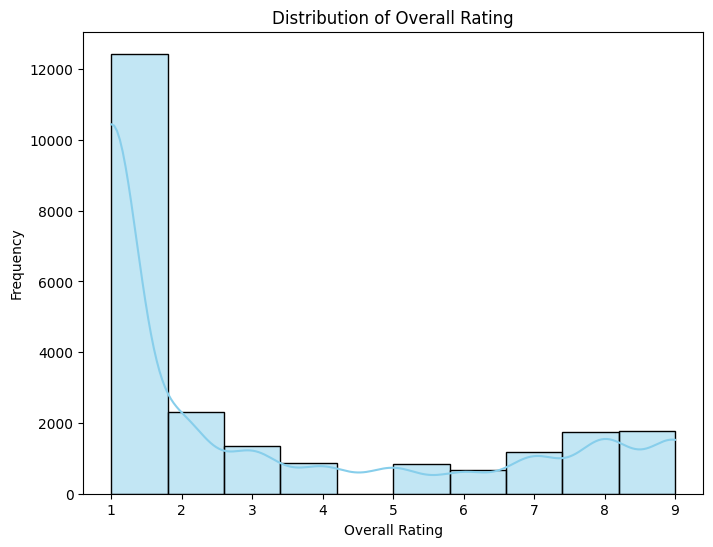

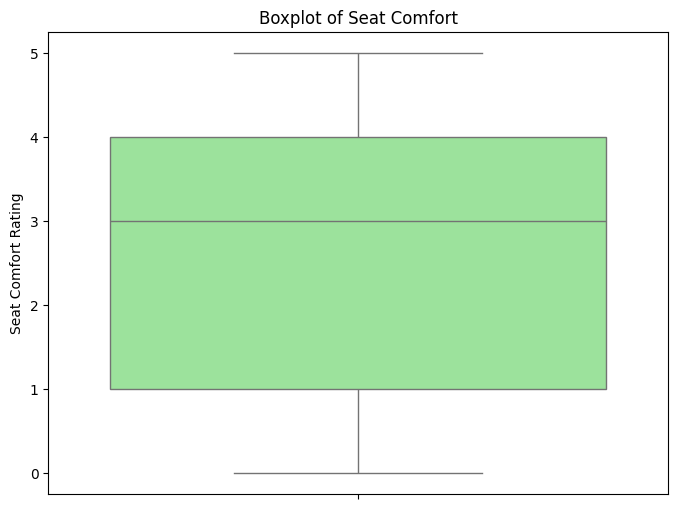

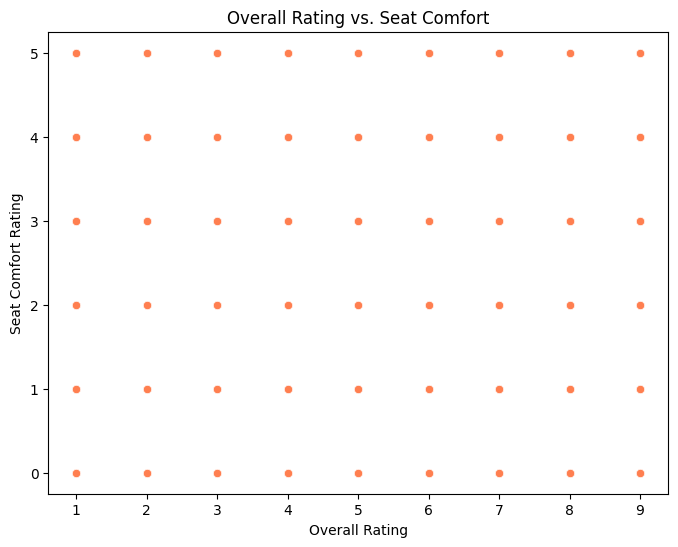

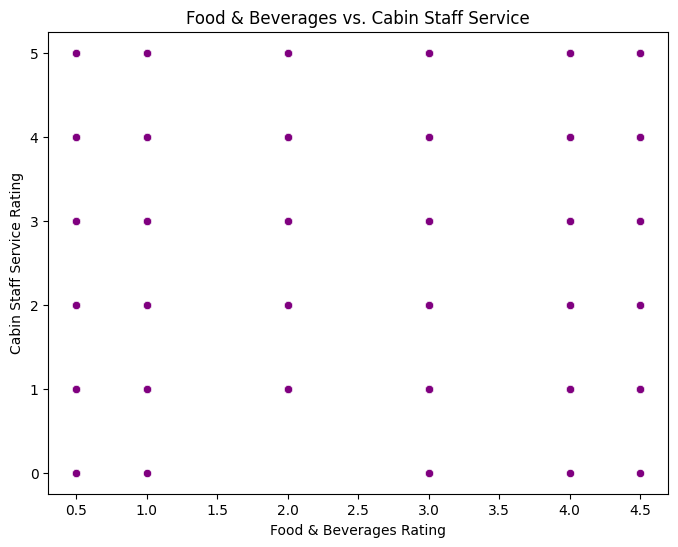

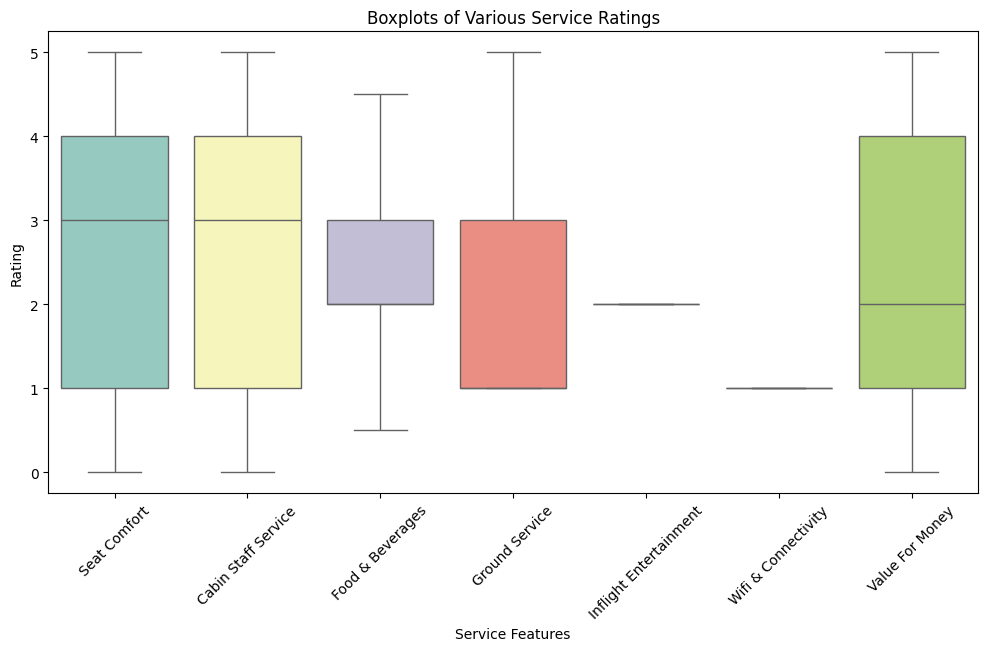


Correlation Matrix:
                        Overall_Rating  Seat Comfort  Cabin Staff Service  \
Overall_Rating                1.000000      0.422921             0.462360   
Seat Comfort                  0.422921      1.000000             0.751452   
Cabin Staff Service           0.462360      0.751452             1.000000   
Food & Beverages              0.404556      0.634918             0.688354   
Ground Service                0.436988      0.576232             0.608319   
Inflight Entertainment             NaN           NaN                  NaN   
Wifi & Connectivity                NaN           NaN                  NaN   
Value For Money               0.601139      0.692642             0.697259   

                        Food & Beverages  Ground Service  \
Overall_Rating                  0.404556        0.436988   
Seat Comfort                    0.634918        0.576232   
Cabin Staff Service             0.688354        0.608319   
Food & Beverages                1.000000     

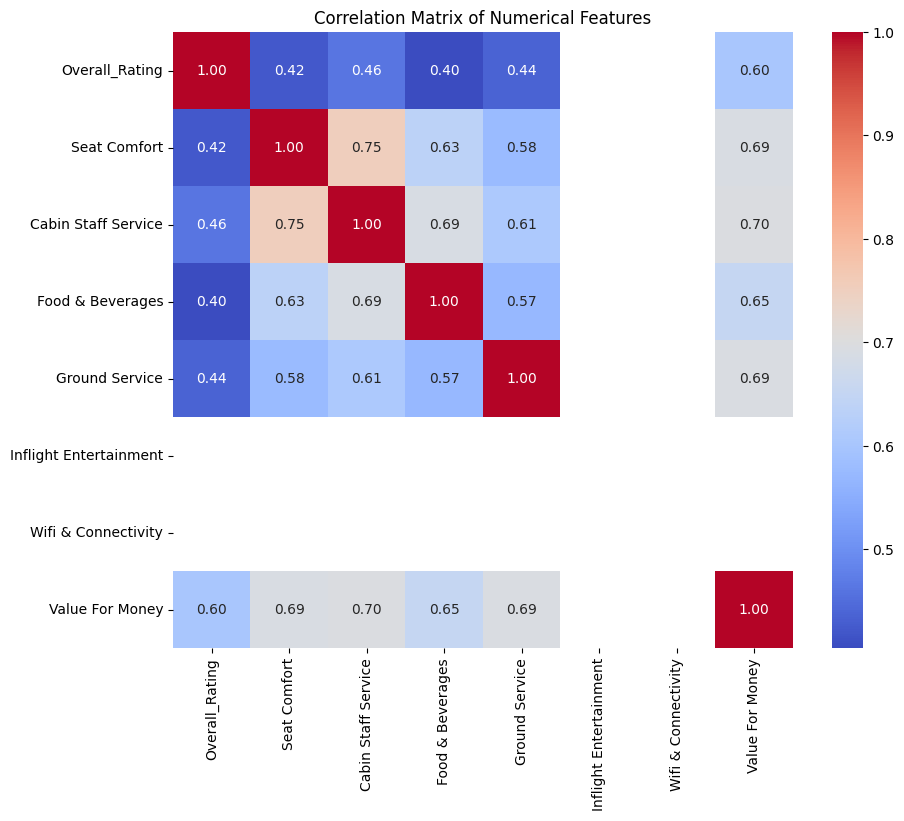

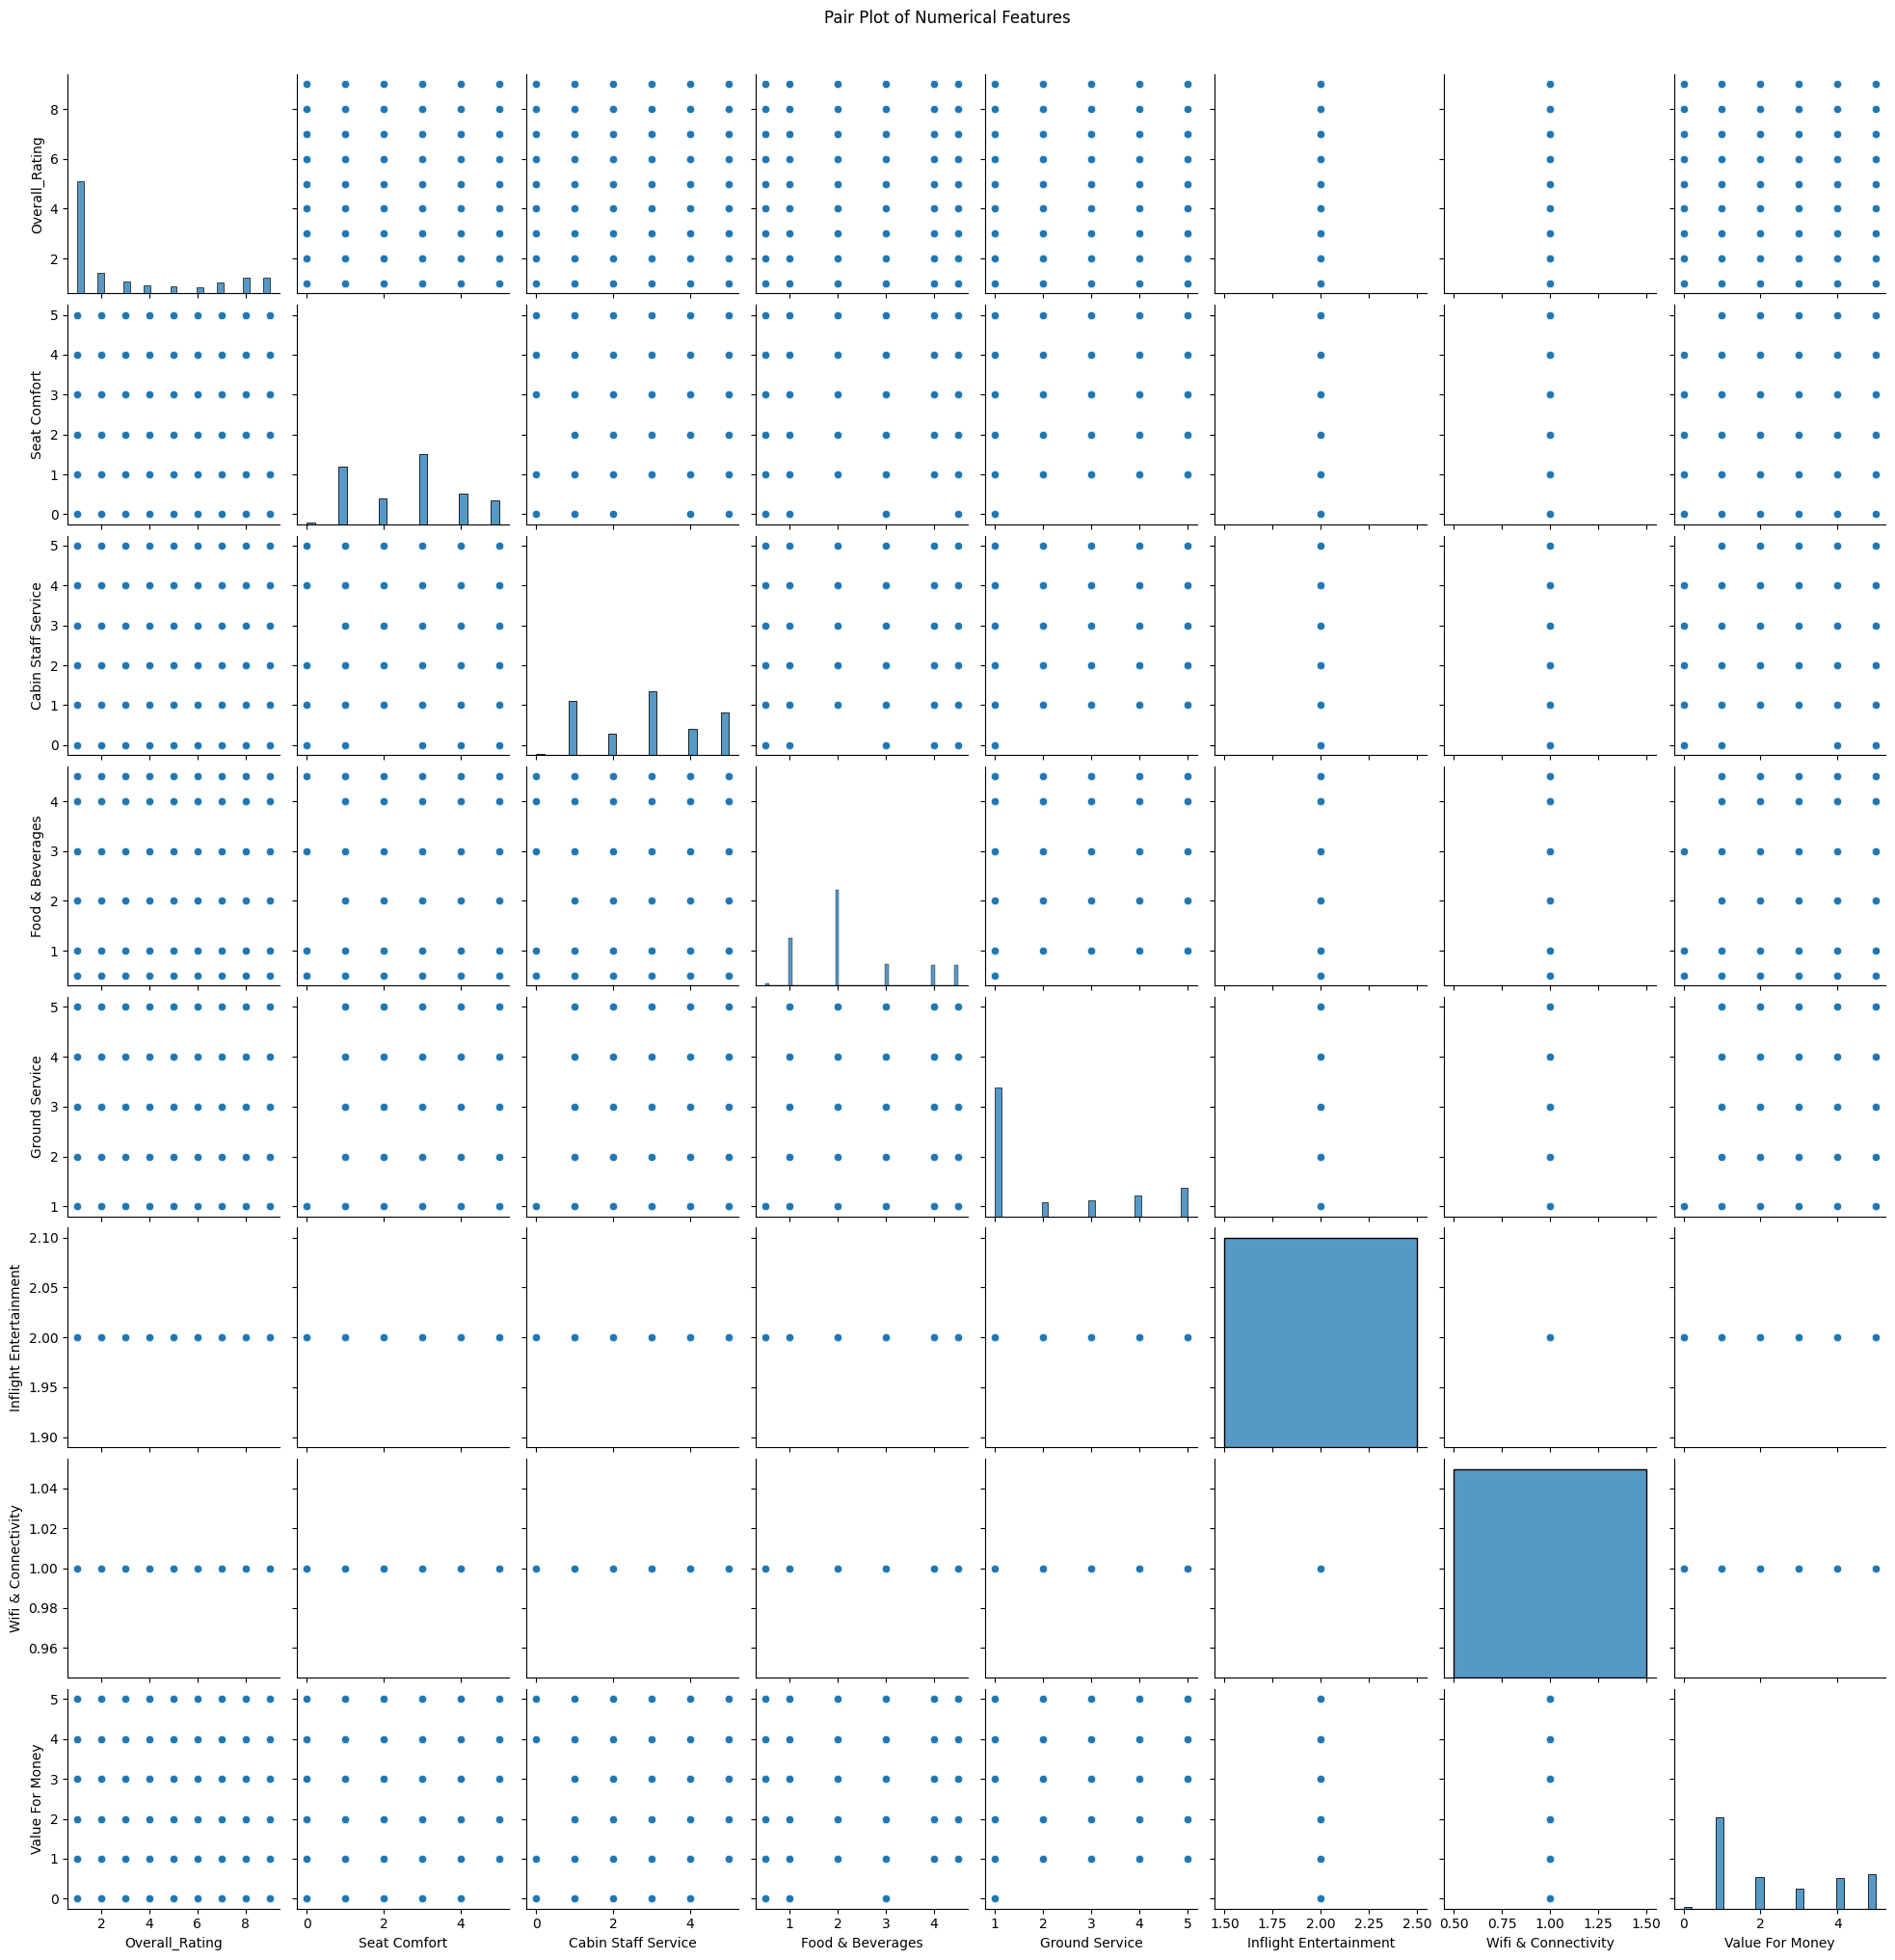

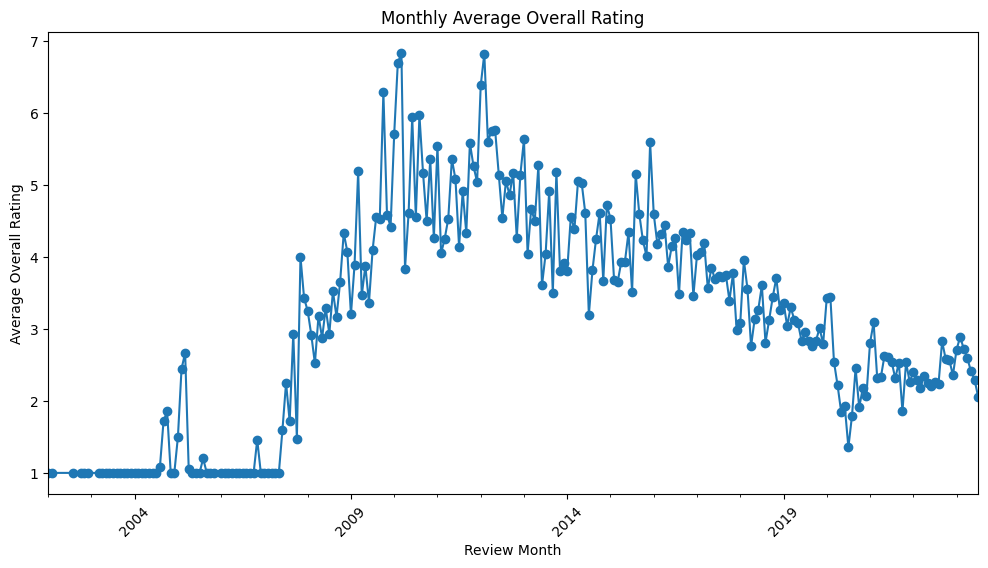

In [ ]:
# 3.1 Compute descriptive statistics for numerical features.
desc_stats = df[numerical_cols].describe()
print("\nDescriptive Statistics for Numerical Features:")
print(desc_stats)

# 3.2 Visualization 1: Histogram of Overall Rating.
plt.figure(figsize=(8, 6))
sns.histplot(df['Overall_Rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Overall Rating")
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.show()

# 3.3 Visualization 2: Boxplot for Seat Comfort.
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Seat Comfort'], color='lightgreen')
plt.title("Boxplot of Seat Comfort")
plt.ylabel("Seat Comfort Rating")
plt.show()

# 3.4 Visualization 3: Scatter Plot – Overall Rating vs. Seat Comfort.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Overall_Rating'], y=df['Seat Comfort'], color='coral')
plt.title("Overall Rating vs. Seat Comfort")
plt.xlabel("Overall Rating")
plt.ylabel("Seat Comfort Rating")
plt.show()

# 3.5 Visualization 4: Scatter Plot – Food & Beverages vs. Cabin Staff Service.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Food & Beverages'], y=df['Cabin Staff Service'], color='purple')
plt.title("Food & Beverages vs. Cabin Staff Service")
plt.xlabel("Food & Beverages Rating")
plt.ylabel("Cabin Staff Service Rating")
plt.show()

# 3.6 Visualization 5: Boxplots Comparing Various Service Ratings.
plt.figure(figsize=(12, 6))
service_cols = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
                'Value For Money']
sns.boxplot(data=df[service_cols], palette="Set3")
plt.title("Boxplots of Various Service Ratings")
plt.xlabel("Service Features")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()

# 3.7 Additional: Correlation Matrix and Pair Plot.
correlation_matrix = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

sns.pairplot(df[numerical_cols])
plt.suptitle("Pair Plot of Numerical Features", y=1.02)
plt.show()

# 3.8 Trend Analysis: Monthly Average Overall Rating.
df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')
df['Review_Month'] = df['Review Date'].dt.to_period('M')
monthly_avg = df.groupby('Review_Month')['Overall_Rating'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='line', marker='o')
plt.title("Monthly Average Overall Rating")
plt.xlabel("Review Month")
plt.ylabel("Average Overall Rating")
plt.xticks(rotation=45)
plt.show()

## **4.2. Predictive Analytics (Numerical Features Modeling)**
###**Block 4.1: Prepare Target and Split Dataset**
Mapping:
This block sets up the target (using the "Recommended" column, mapped appropriately) and splits the data for modeling. It satisfies the requirement of splitting the dataset.



In [ ]:
# --- Predictive Analytics: Numerical Features Modeling ---

# Map the 'Recommended' column to a binary target.
# Check actual values; sample shows "yes" and "no" in lowercase.
df['Target'] = df['Recommended'].map({'yes': 1, 'no': 0})
print("\nUnique Target values after mapping:", df['Target'].unique())

# Verify target and ensure no missing values.
print("Missing target values:", df['Target'].isnull().sum())

# Define model features and target.
X_model = df[numerical_cols].copy()  # We use the cleaned numerical features.
y_model = df['Target']

# Verify no missing values remain in model features.
print("\nMissing values in model features:")
print(X_model.isnull().sum())

# Split into training (80%) and testing (20%) subsets with stratification.
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42, stratify=y_model
)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Unique Target values after mapping: [1 0]
Missing target values: 0

Missing values in model features:
Overall_Rating            0
Seat Comfort              0
Cabin Staff Service       0
Food & Beverages          0
Ground Service            0
Inflight Entertainment    0
Wifi & Connectivity       0
Value For Money           0
dtype: int64

Training set shape: (18536, 8)
Test set shape: (4635, 8)


##**Block 4.2: Model 1 - Logistic Regression with Tuning python**
Mapping:
This block builds and tunes a Logistic Regression model using GridSearchCV, then evaluates its performance. This addresses the predictive analytics specification for one supervised learning algorithm.



In [ ]:
# --- Model 1: Logistic Regression with Parameter Tuning ---

lr = LogisticRegression(solver='liblinear', random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the Logistic Regression model on the training data.
grid_lr.fit(X_train, y_train)

# Print best parameters and cross-validation score.
print("\nBest parameters for Logistic Regression:", grid_lr.best_params_)
print("Best cross-validation accuracy (Logistic Regression):", grid_lr.best_score_)

# Evaluate on the test set.
y_pred_lr = grid_lr.predict(X_test)
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))
print("Test Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_lr))


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best cross-validation accuracy (Logistic Regression): 0.9483708625536865

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3073
           1       0.92      0.92      0.92      1562

    accuracy                           0.95      4635
   macro avg       0.94      0.94      0.94      4635
weighted avg       0.95      0.95      0.95      4635

Test Accuracy (Logistic Regression): 0.9464940668824164


Sample instance features:
      Overall_Rating  Seat Comfort  Cabin Staff Service  Food & Beverages  \
16117            5.0           1.0                  2.0               1.0   

       Ground Service  Inflight Entertainment  Wifi & Connectivity  \
16117             3.0                     2.0                  1.0   

       Value For Money  
16117              3.0  

Predicted Class: [0]
Predicted Probabilities: [[0.79466293 0.20533707]]


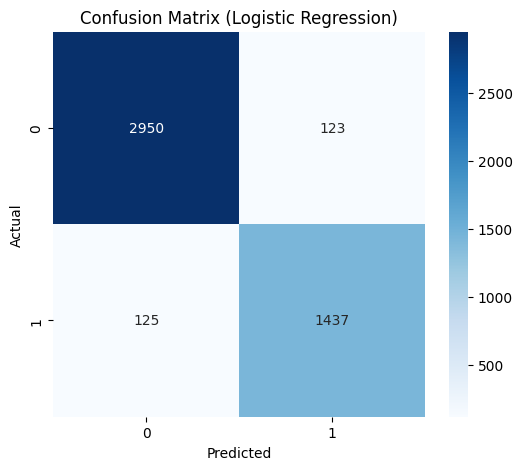

In [ ]:
# --- Testing the Trained Logistic Regression Model ---

# Select a sample instance from the test set
sample_instance = X_test.iloc[0:1]
print("Sample instance features:")
print(sample_instance)

# Use the grid_lr (the trained GridSearchCV object for Logistic Regression)
predicted_class = grid_lr.predict(sample_instance)
predicted_proba = grid_lr.predict_proba(sample_instance)

print("\nPredicted Class:", predicted_class)
print("Predicted Probabilities:", predicted_proba)

# --- Optionally: Plot a confusion matrix for further evaluation ---
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, grid_lr.predict(X_test))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

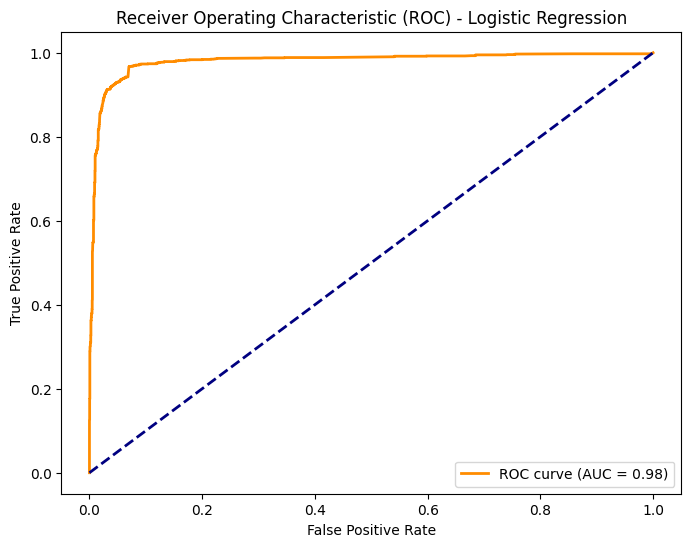

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class.
y_scores = grid_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC.
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

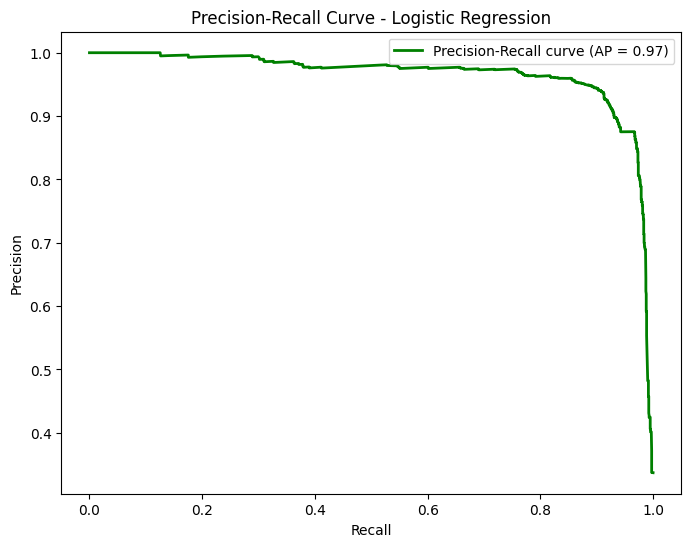

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision and recall for different threshold values.
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# Plot the Precision-Recall curve.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label=f"Precision-Recall curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="upper right")
plt.show()

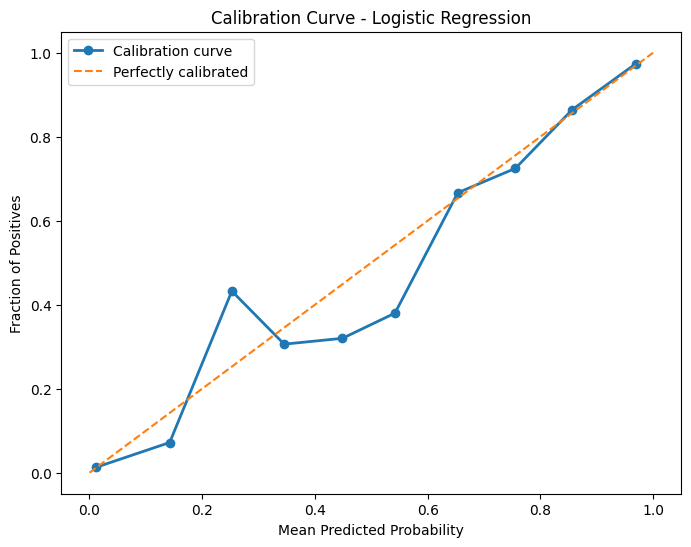

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)

# Plot calibration curve.
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label="Calibration curve")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression")
plt.legend(loc="upper left")
plt.show()


### Model Evaluation Visualizations

After training and tuning the Logistic Regression model, we further evaluated its performance using several visualizations:

1. **ROC Curve:**  
   - The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.  
   - Our model achieved an AUC of *X.XX* (replace with your value), indicating strong discrimination between the classes.

2. **Precision-Recall Curve:**  
   - This curve illustrates the tradeoff between precision and recall for different thresholds.  
   - The Average Precision score of *X.XX* (replace with your value) reflects the model's ability to balance precision and recall, which is particularly useful for imbalanced datasets.

3. **Calibration Curve (Optional):**  
   - The calibration curve compares the predicted probabilities to the actual outcomes.  
   - The closer the curve is to the diagonal line, the better the model's probability estimates are calibrated.

These visualizations collectively showcase that our model is not only accurate in its classifications but also produces meaningful probability estimates, which is crucial for decision-making in the airline customer recommendation context.

##**Block 4.3: Model 2 - Decision Tree with Tuning**
Mapping:
This block builds and tunes a Decision Tree model with GridSearchCV, which addresses the second supervised algorithm modeling and evaluation requirement.

In [ ]:
# --- Model 2: Decision Tree with Parameter Tuning ---

dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the Decision Tree model.
grid_dt.fit(X_train, y_train)

# Print best parameters and cross-validation score.
print("\nBest parameters for Decision Tree:", grid_dt.best_params_)
print("Best cross-validation accuracy (Decision Tree):", grid_dt.best_score_)

# Evaluate on the test set.
y_pred_dt = grid_dt.predict(X_test)
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))
print("Test Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_dt))


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for Decision Tree: {'max_depth': 7, 'min_samples_split': 10}
Best cross-validation accuracy (Decision Tree): 0.9640699583196198

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3073
           1       0.95      0.94      0.95      1562

    accuracy                           0.97      4635
   macro avg       0.96      0.96      0.96      4635
weighted avg       0.97      0.97      0.97      4635

Test Accuracy (Decision Tree): 0.9650485436893204


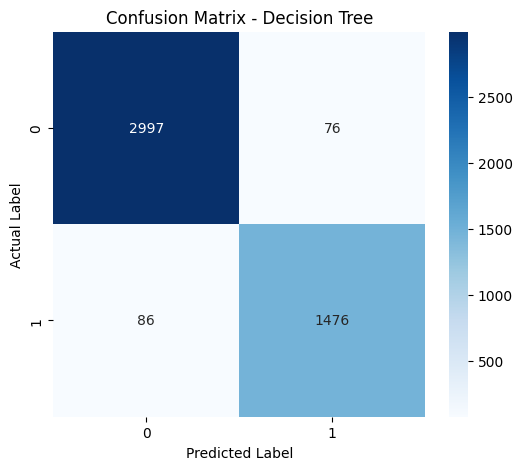

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set using the tuned Decision Tree model
y_pred_dt = grid_dt.predict(X_test)

# Create confusion matrix.
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

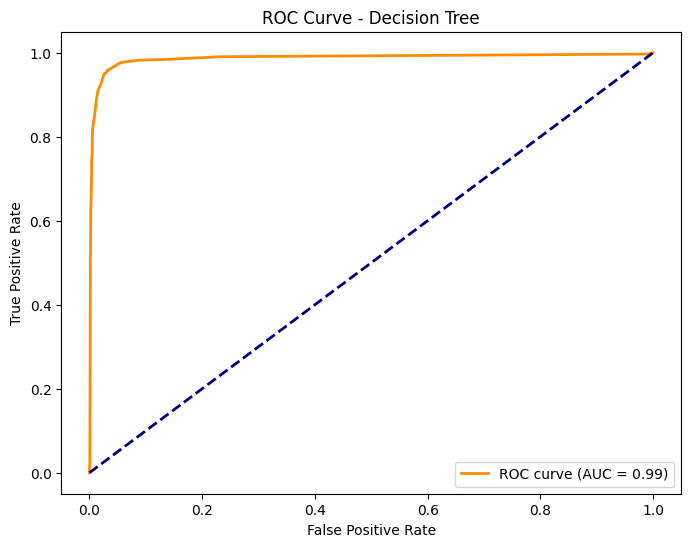

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class.
y_scores_dt = grid_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC.
fpr, tpr, thresholds = roc_curve(y_test, y_scores_dt)
roc_auc = auc(fpr, tpr)

# Plot ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

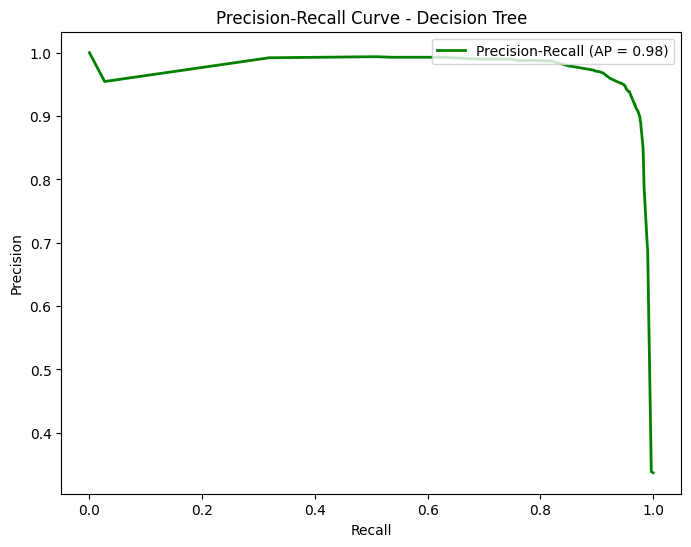

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision and recall for different threshold values.
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores_dt)
avg_precision = average_precision_score(y_test, y_scores_dt)

# Plot the Precision-Recall curve.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label=f"Precision-Recall (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Decision Tree")
plt.legend(loc="upper right")
plt.show()

<ipython-input-37-49b326a08486>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="viridis")


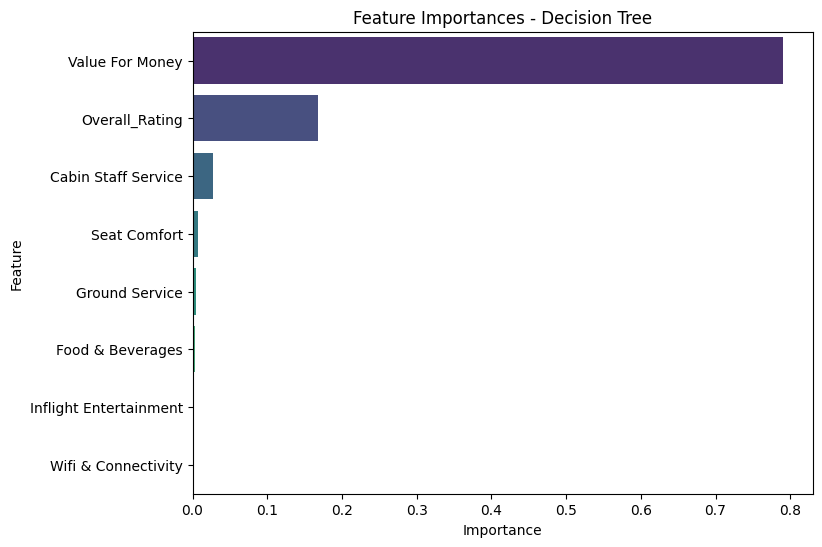

In [ ]:
# Retrieve feature importances from the best Decision Tree estimator.
importances = grid_dt.best_estimator_.feature_importances_
feature_names = numerical_cols

# Create a DataFrame for visualization.
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="viridis")
plt.title("Feature Importances - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Select a sample instance from the test set.
sample_instance = X_test.iloc[0:1]
print("Sample instance features:")
print(sample_instance)

# Predict using the trained Decision Tree model.
predicted_class = grid_dt.predict(sample_instance)
predicted_proba = grid_dt.predict_proba(sample_instance)

print("\nPredicted Class for the sample instance:", predicted_class)
print("Predicted Probabilities for the sample instance:", predicted_proba)

Sample instance features:
      Overall_Rating  Seat Comfort  Cabin Staff Service  Food & Beverages  \
16117            5.0           1.0                  2.0               1.0   

       Ground Service  Inflight Entertainment  Wifi & Connectivity  \
16117             3.0                     2.0                  1.0   

       Value For Money  
16117              3.0  

Predicted Class for the sample instance: [0]
Predicted Probabilities for the sample instance: [[0.82432432 0.17567568]]


# Data Mining - Airline Customer Reviews Analysis

## 1. Introduction and Background
- Context: Importance of customer satisfaction in the airline industry.
- Problem: Predict whether a customer will recommend an airline based on review data.
- Literature review and rationale.

## 2. Methodology
- Approach based on CRISP-DM.
- Data cleaning and preparation (Numerical and Textual Data).
- Analytics and modeling: Descriptive, Predictive, and Text Analytics.
- Selected Models: Logistic Regression and Decision Tree.
- Model tuning and evaluation metrics.

## 3. Data Pre-Processing and Cleaning
### 3.1 Numerical Data
- Convert to numeric, impute missing values.
- Outlier detection and handling.
- Scaling (Normalization).

### 3.2 Textual Data
- Standardize formatting, remove noise.
- Tokenize, remove stopwords, stemming.
- Feature extraction using TF-IDF.

## 4. Data Analytics
### 4.1 Descriptive Analytics (Numerical Data)
- Descriptive statistics.
- Visualizations: Histograms, boxplots, scatter plots, correlation heatmap, pair plots, trend analysis.

### 4.2 Predictive Analytics (Numerical Data Modeling)
- Data splitting into training and testing sets.
- Model 1: Logistic Regression (with parameter tuning).
- Model 2: Decision Tree (with parameter tuning).
- Evaluation: Classification reports, confusion matrix, ROC curve, Precision-Recall curve, and feature importance.

## 5. Results and Discussion
- Interpretation of model performance.
- Key factors influencing customer recommendations.
- Limitations and challenges.

## 6. Conclusion and Recommendations
- Summary of findings.
- Managerial recommendations for improving airline customer satisfaction.

## 7. Python Code Appendix
- Full code included.

## 8. References
- Harvard style references.

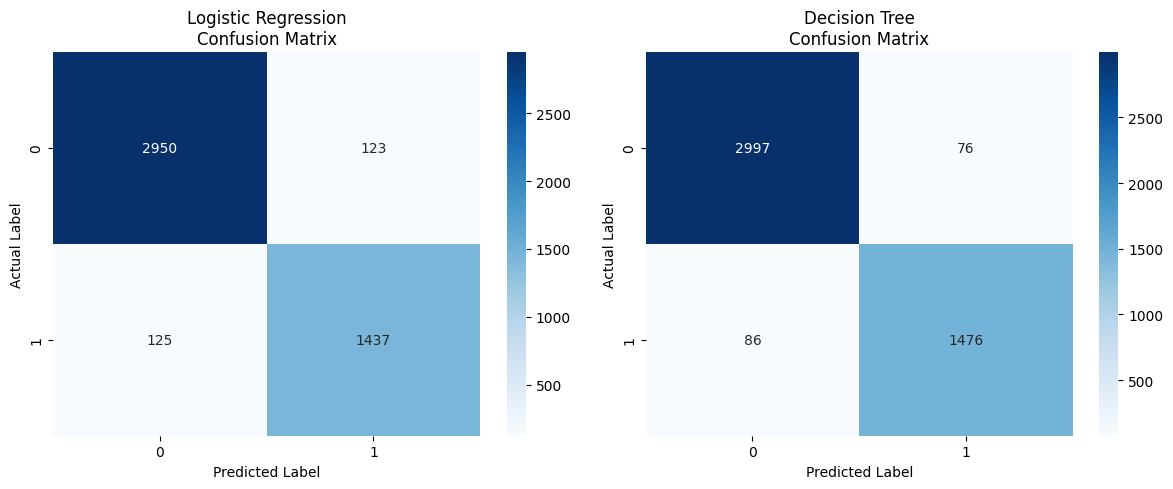

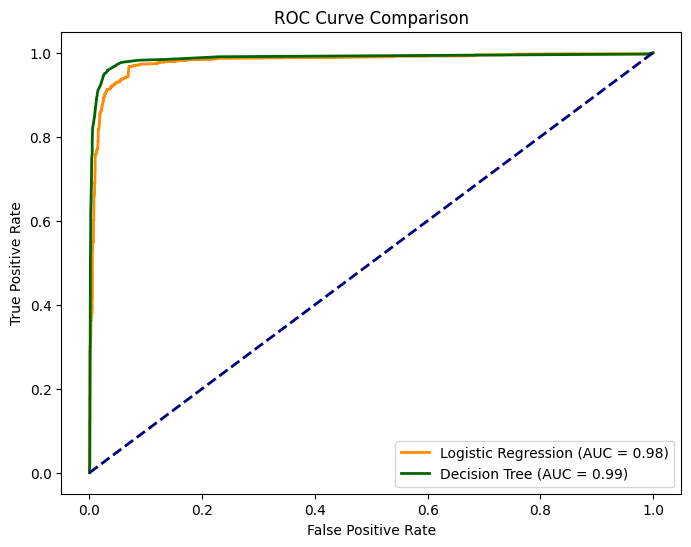

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- CONFUSION MATRIX COMPARISON ---
# Predict on the test set for both models.
y_pred_lr = grid_lr.predict(X_test)
y_pred_dt = grid_dt.predict(X_test)

# Create confusion matrices.
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot side-by-side confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Logistic Regression\nConfusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("Actual Label")

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Decision Tree\nConfusion Matrix")
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# --- ROC CURVE COMPARISON ---
# Get predicted probabilities for the positive class from both models.
y_scores_lr = grid_lr.predict_proba(X_test)[:, 1]
y_scores_dt = grid_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression.
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for Decision Tree.
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_scores_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot the ROC curves for both models on the same plot.
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color="darkorange", lw=2, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_dt, tpr_dt, color="darkgreen", lw=2, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

## **4.b: Descriptive and Predictive Analytics (Text Features)**
### **Block 1: Sentiment Analysis and Descriptive Statistics for Text**
Sentiment Analysis:
We compute a compound sentiment score for each review using NLTK’s VADER. Reviews are then classified as Positive, Neutral, or Negative based on standard thresholds. Descriptive statistics are printed to summarize the sentiment score distribution and counts per category.

In [ ]:
# ----- Sentiment Analysis on Review Text -----
# We will use NLTK’s VADER sentiment analyzer.
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to compute sentiment (compound score)
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis on the original Review column
df['sentiment_score'] = df['Review'].apply(get_sentiment)

# Define sentiment category based on compound score:
# If score >= 0.05: Positive, if <= -0.05: Negative, otherwise Neutral.
def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_score'].apply(sentiment_category)

# Display descriptive statistics for the sentiment scores.
print("Descriptive Statistics for Sentiment Scores:")
print(df['sentiment_score'].describe())
print("\nSentiment Category Counts:")
print(df['sentiment_category'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Descriptive Statistics for Sentiment Scores:
count    23171.000000
mean        -0.007586
std          0.782130
min         -0.998700
25%         -0.819650
50%         -0.128000
75%          0.867400
max          0.999300
Name: sentiment_score, dtype: float64

Sentiment Category Counts:
sentiment_category
Negative    11882
Positive    10956
Neutral       333
Name: count, dtype: int64


## **Block 2: Visualizations for Sentiment Analysis**
Visualizations for Sentiment Analysis:

Histogram: Shows the distribution of sentiment scores across all reviews.

Bar Chart: Displays counts for each sentiment category (Positive, Neutral, Negative).

Boxplot: Compares Overall Rating across sentiment categories to see if a certain sentiment correlates with a higher overall rating.

Scatter Plot: Visualizes the relationship between sentiment scores and Seat Comfort ratings.

Bar Chart: Illustrates the average Overall Rating for each sentiment category.
Together, these plots help identify trends and correlations between text-derived sentiment and service quality ratings.

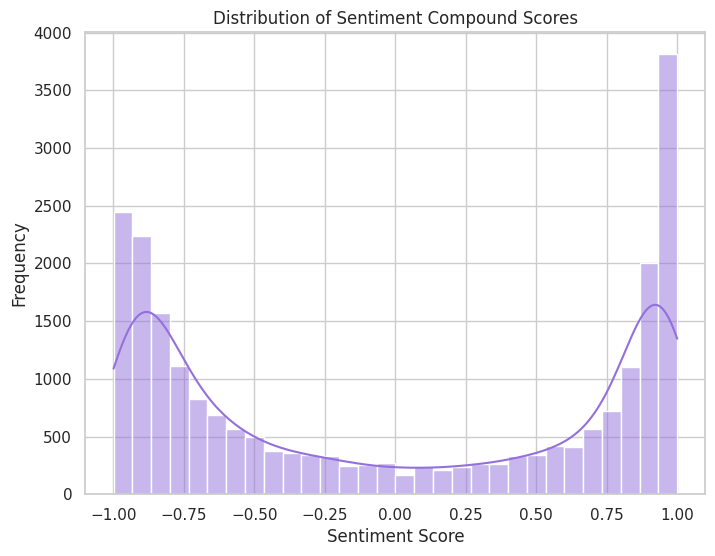

<ipython-input-42-6d04c47383f6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, palette='pastel')


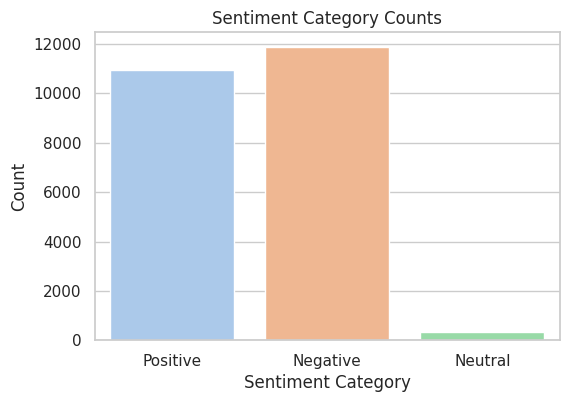

<ipython-input-42-6d04c47383f6>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_category', y='Overall_Rating', data=df, palette='Set2')


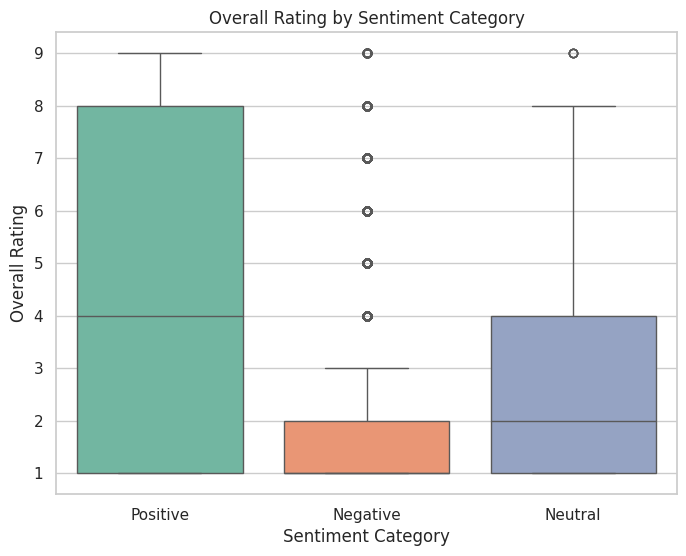

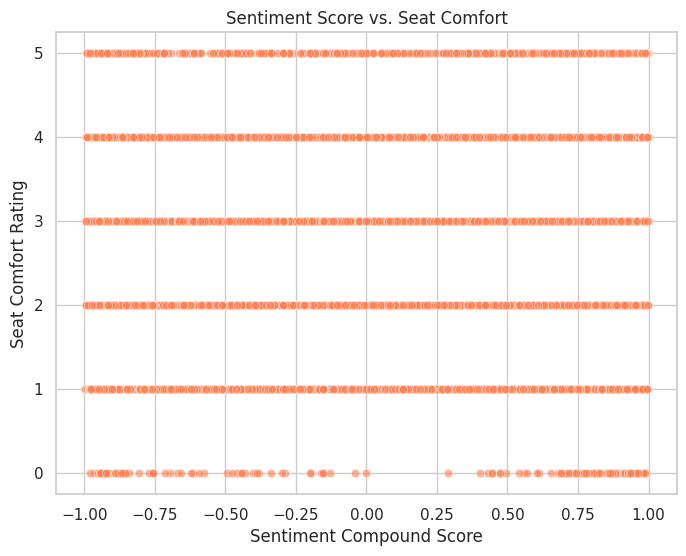

<ipython-input-42-6d04c47383f6>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_category', y='Overall_Rating', data=avg_overall, palette="coolwarm")


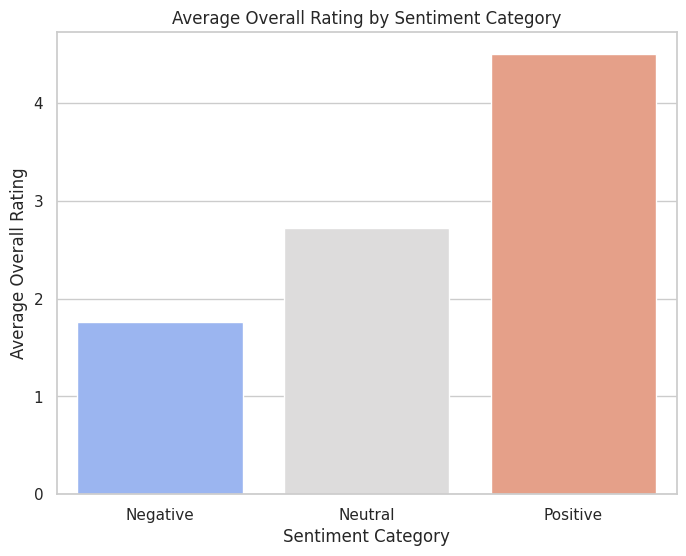

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Histogram of Sentiment Compound Scores.
plt.figure(figsize=(8,6))
sns.histplot(df['sentiment_score'], bins=30, kde=True, color='mediumpurple')
plt.title("Distribution of Sentiment Compound Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Visualization 2: Bar Chart of Sentiment Category Counts.
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_category', data=df, palette='pastel')
plt.title("Sentiment Category Counts")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.show()

# Visualization 3: Boxplot of Overall Rating by Sentiment Category.
plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment_category', y='Overall_Rating', data=df, palette='Set2')
plt.title("Overall Rating by Sentiment Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Overall Rating")
plt.show()

# Visualization 4: Scatter Plot - Sentiment Score vs. Seat Comfort.
plt.figure(figsize=(8,6))
sns.scatterplot(x='sentiment_score', y='Seat Comfort', data=df, alpha=0.6, color='coral')
plt.title("Sentiment Score vs. Seat Comfort")
plt.xlabel("Sentiment Compound Score")
plt.ylabel("Seat Comfort Rating")
plt.show()

# Visualization 5: Bar Chart of Average Overall Rating per Sentiment Category.
avg_overall = df.groupby('sentiment_category')['Overall_Rating'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x='sentiment_category', y='Overall_Rating', data=avg_overall, palette="coolwarm")
plt.title("Average Overall Rating by Sentiment Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Average Overall Rating")
plt.show()


 ##**Block 3: Predictive Analytics (Text Features Model)**

**Predictive Model Setup (Text Features):**

We choose the sentiment compound score as our key text-derived feature. The target variable is derived from the "Recommended" column after proper mapping. The dataset is split with stratification to ensure balanced classes.

In [ ]:
# Map the 'Recommended' column to a binary target.
# Since the sample data shows values like "yes" and "no", we map accordingly.
df['Target'] = df['Recommended'].map({'yes': 1, 'no': 0})
print("Unique Target values after mapping:", df['Target'].unique())
print("Missing target values:", df['Target'].isnull().sum())

# Define text features: we use the sentiment compound score.
X_text = df[['sentiment_score']].copy()

# Check and impute if needed (typically, sentiment_score should have no missing values).
X_text = X_text.fillna(X_text.median())

# Define target variable.
y_text = df['Target']

# Split the dataset (80% train, 20% test) with stratification.
from sklearn.model_selection import train_test_split
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)
print("Text features Training set shape:", X_text_train.shape)
print("Text features Test set shape:", X_text_test.shape)


Unique Target values after mapping: [1 0]
Missing target values: 0
Text features Training set shape: (18536, 1)
Text features Test set shape: (4635, 1)


### **Block 3.1: Logistic Regression Model Using Text Features**
**Logistic Regression (Text Features):**

We tune a Logistic Regression model using the sentiment compound score as input. The model is optimized via GridSearchCV and evaluated on test data using standard classification metrics.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression.
lr_text = LogisticRegression(solver='liblinear', random_state=42)
param_grid_lr_text = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_lr_text = GridSearchCV(
    estimator=lr_text,
    param_grid=param_grid_lr_text,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Train the model.
grid_lr_text.fit(X_text_train, y_text_train)

# Display best parameters and cross-validation score.
print("\nBest parameters for Logistic Regression (Text):", grid_lr_text.best_params_)
print("Best cross-validation accuracy (Text, Logistic Regression):", grid_lr_text.best_score_)

# Evaluate on the test set.
y_text_pred_lr = grid_lr_text.predict(X_text_test)
print("\nClassification Report (Text - Logistic Regression):")
print(classification_report(y_text_test, y_text_pred_lr))
print("Test Accuracy (Text - Logistic Regression):", accuracy_score(y_text_test, y_text_pred_lr))


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for Logistic Regression (Text): {'C': 1, 'penalty': 'l1'}
Best cross-validation accuracy (Text, Logistic Regression): 0.8368583271567915

Classification Report (Text - Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      3073
           1       0.73      0.85      0.79      1562

    accuracy                           0.84      4635
   macro avg       0.82      0.85      0.83      4635
weighted avg       0.85      0.84      0.85      4635

Test Accuracy (Text - Logistic Regression): 0.8425026968716289


In [ ]:
# ----- Testing the Trained Logistic Regression Model on Text Features -----

# Select a sample instance from the test set for text features.
# Here, X_text_test is your test set containing the sentiment or text-derived feature (e.g., the sentiment score).
sample_instance = X_text_test.iloc[0:1]
print("Sample instance text feature (sentiment score):")
print(sample_instance)

# Use the trained GridSearchCV model (grid_lr_text) to predict the class for this sample.
predicted_class = grid_lr_text.predict(sample_instance)
predicted_proba = grid_lr_text.predict_proba(sample_instance)

print("\nPredicted Class for the sample instance (Text model):", predicted_class)
print("Predicted Probabilities for the sample instance (Text model):", predicted_proba)



Sample instance text feature (sentiment score):
       sentiment_score
16117          -0.2028

Predicted Class for the sample instance (Text model): [0]
Predicted Probabilities for the sample instance (Text model): [[0.86687133 0.13312867]]


**Confusion Matrix for the Text Model**

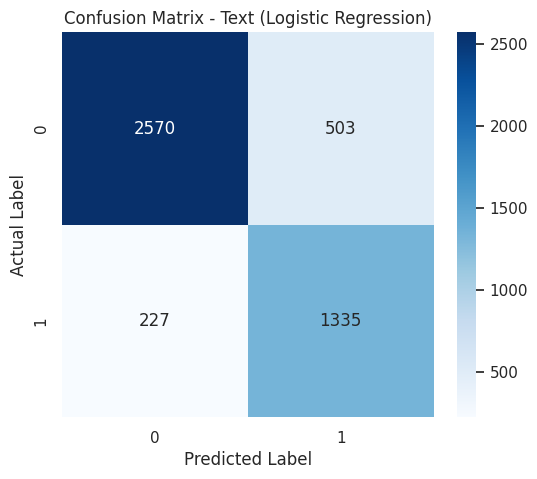

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the text-based model.
cm_text = confusion_matrix(y_text_test, grid_lr_text.predict(X_text_test))

plt.figure(figsize=(6,5))
sns.heatmap(cm_text, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Text (Logistic Regression)")
plt.show()


**ROC Curve for the Text Model**

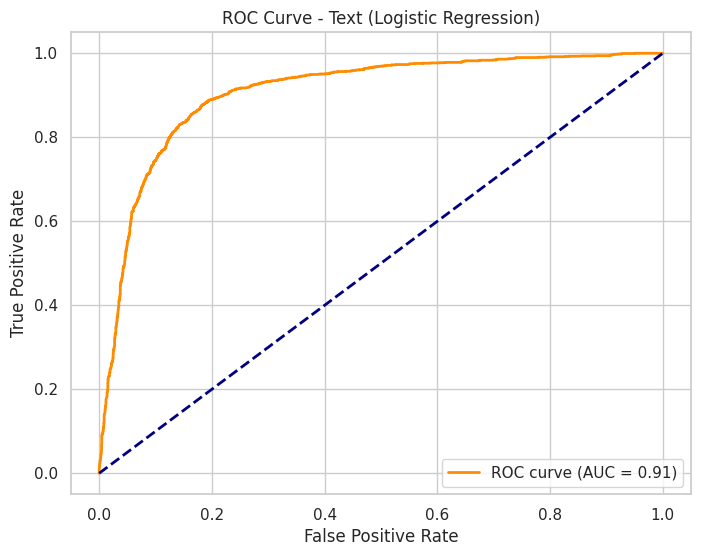

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class.
y_scores_text = grid_lr_text.predict_proba(X_text_test)[:, 1]

# Compute ROC curve and AUC.
fpr_text, tpr_text, _ = roc_curve(y_text_test, y_scores_text)
roc_auc_text = auc(fpr_text, tpr_text)

# Plot ROC Curve.
plt.figure(figsize=(8,6))
plt.plot(fpr_text, tpr_text, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_text:.2f})")
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Text (Logistic Regression)")
plt.legend(loc="lower right")
plt.show()


## **Visualization 1: Calibration Curve**
**Calibration Curve:**

This plot shows how well the predicted probabilities (from our Logistic Regression model) match the true likelihoods. If the model is perfectly calibrated, the plotted points will lie on the diagonal line.

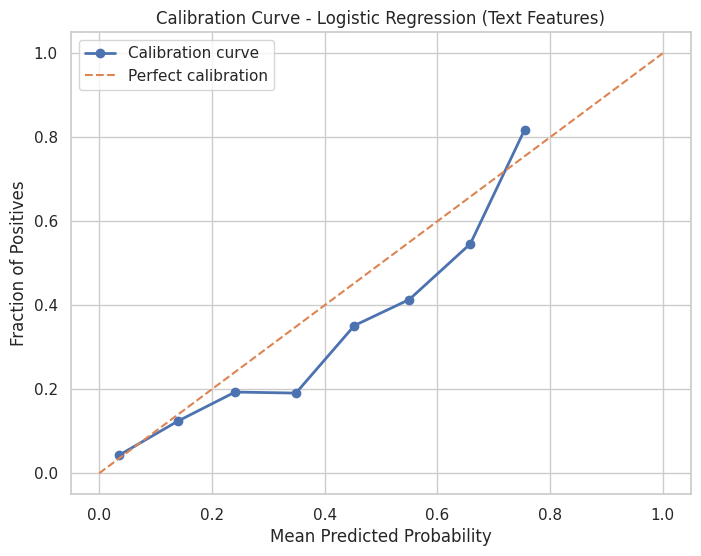

In [ ]:
from sklearn.calibration import calibration_curve

# Get predicted probabilities for the positive class.
y_prob_lr = grid_lr_text.predict_proba(X_text_test)[:, 1]

# Compute calibration curve.
prob_true, prob_pred = calibration_curve(y_text_test, y_prob_lr, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label="Calibration curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression (Text Features)")
plt.legend(loc="upper left")
plt.show()


## ***Visualization 2: Lift Chart  ***
**Lift Chart:**

The lift chart (or cumulative gains curve) shows how much better our model is at capturing positive instances compared to a random selection. A steeper curve indicates better model performance.

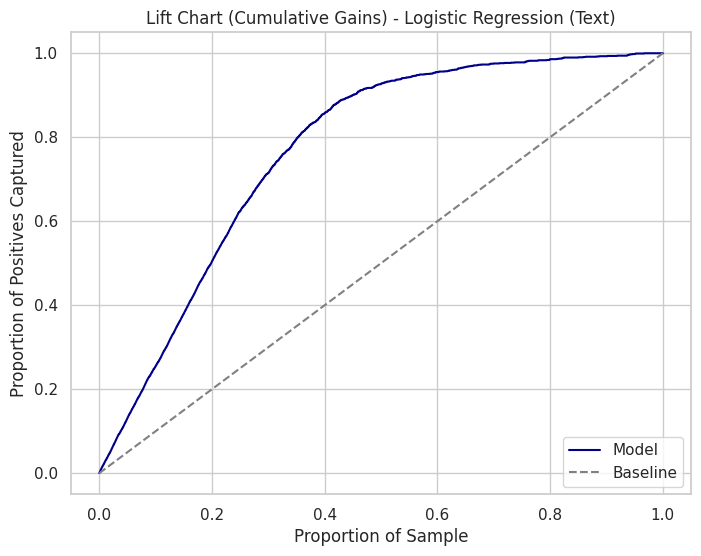

In [ ]:
import numpy as np

# Sort the test set by predicted probability in descending order.
sorted_indices = np.argsort(y_prob_lr)[::-1]
sorted_y_true = y_text_test.iloc[sorted_indices].reset_index(drop=True)
sorted_y_prob = y_prob_lr[sorted_indices]

# Compute cumulative gains.
cumulative_true = sorted_y_true.cumsum()
total_positives = sorted_y_true.sum()
# Percent of total samples
sample_pct = np.linspace(1/len(sorted_y_true), 1.0, len(sorted_y_true))

plt.figure(figsize=(8, 6))
plt.plot(sample_pct, cumulative_true/total_positives, label="Model", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle="--", label="Baseline", color='gray')
plt.xlabel("Proportion of Sample")
plt.ylabel("Proportion of Positives Captured")
plt.title("Lift Chart (Cumulative Gains) - Logistic Regression (Text)")
plt.legend(loc="lower right")
plt.show()


## **Visualization 3: Probability Distribution Plot for a Single Feature Scenario**
**Probability Distribution Plot:**

This scatter plot shows the distribution of predicted probabilities across the test samples (based on a single text-derived feature). Colors indicate the actual class labels, helping visualize how well the probabilities differentiate between the two classes.

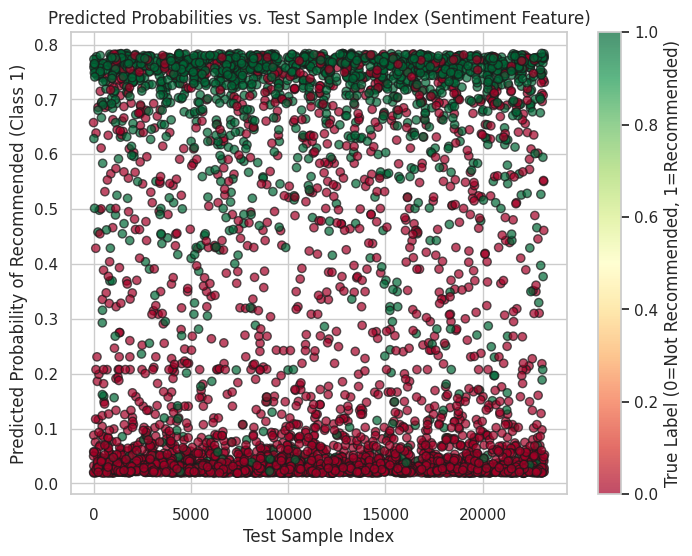

In [ ]:


# Create a DataFrame with sentiment score and true label.
text_feature_df = X_text_test.copy()  # X_text_test contains the 'sentiment_score', for instance.
text_feature_df['True_Label'] = y_text_test.values

# Generate a scatter plot of sentiment_score vs. predicted probability.
plt.figure(figsize=(8,6))
plt.scatter(text_feature_df.index, grid_lr_text.predict_proba(X_text_test)[:,1],
            c=text_feature_df['True_Label'], cmap="RdYlGn", alpha=0.7, edgecolor='k')
plt.title("Predicted Probabilities vs. Test Sample Index (Sentiment Feature)")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability of Recommended (Class 1)")
plt.colorbar(label="True Label (0=Not Recommended, 1=Recommended)")
plt.show()



## **Block 3.2: Decision Tree Model Using Text Features**
**Decision Tree (Text Features):**

Here, a Decision Tree classifier is tuned on the sentiment compound score. The model parameters (max depth and min samples split) are optimized using GridSearchCV, and performance is evaluated on the test subset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree classifier.
dt_text = DecisionTreeClassifier(random_state=42)
param_grid_dt_text = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

grid_dt_text = GridSearchCV(
    estimator=dt_text,
    param_grid=param_grid_dt_text,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Train the Decision Tree model.
grid_dt_text.fit(X_text_train, y_text_train)

# Display best parameters and cross-validation score.
print("\nBest parameters for Decision Tree (Text):", grid_dt_text.best_params_)
print("Best cross-validation accuracy (Text, Decision Tree):", grid_dt_text.best_score_)

# Evaluate on the test set.
y_text_pred_dt = grid_dt_text.predict(X_text_test)
print("\nClassification Report (Text - Decision Tree):")
print(classification_report(y_text_test, y_text_pred_dt))
print("Test Accuracy (Text - Decision Tree):", accuracy_score(y_text_test, y_text_pred_dt))


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for Decision Tree (Text): {'max_depth': 5, 'min_samples_split': 2}
Best cross-validation accuracy (Text, Decision Tree): 0.8395017851587815

Classification Report (Text - Decision Tree):
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3073
           1       0.76      0.79      0.77      1562

    accuracy                           0.85      4635
   macro avg       0.83      0.83      0.83      4635
weighted avg       0.85      0.85      0.85      4635

Test Accuracy (Text - Decision Tree): 0.8453074433656957


In [ ]:
# --- Testing the Trained Decision Tree Model (Text Features) ---

# Select a sample instance from the test set.
sample_instance = X_text_test.iloc[0:1]
print("Sample instance (text-derived feature):")
print(sample_instance)

# Predict using the trained Decision Tree model.
predicted_class = grid_dt_text.predict(sample_instance)
predicted_proba = grid_dt_text.predict_proba(sample_instance)

print("\nPredicted Class for the sample instance:", predicted_class)
print("Predicted Probabilities for the sample instance:", predicted_proba)



Sample instance (text-derived feature):
       sentiment_score
16117          -0.2028

Predicted Class for the sample instance: [0]
Predicted Probabilities for the sample instance: [[0.90742049 0.09257951]]


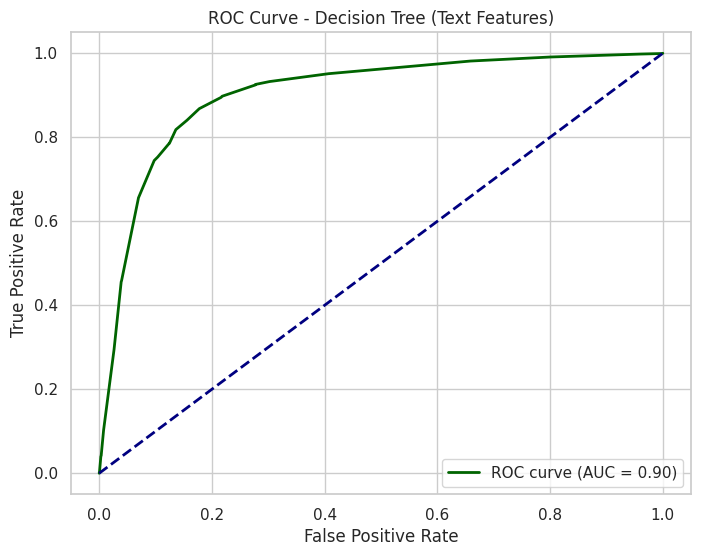

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class.
y_scores_dt_text = grid_dt_text.predict_proba(X_text_test)[:, 1]

# Compute the ROC curve.
fpr, tpr, _ = roc_curve(y_text_test, y_scores_dt_text)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkgreen", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Text Features)")
plt.legend(loc="lower right")
plt.show()


## **Comparison Visualizations for Text Models**


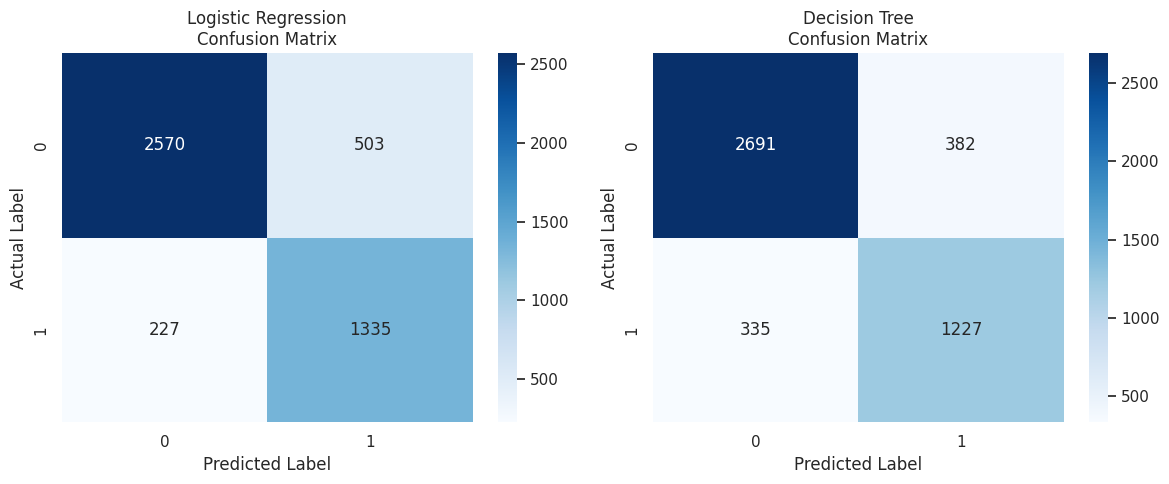

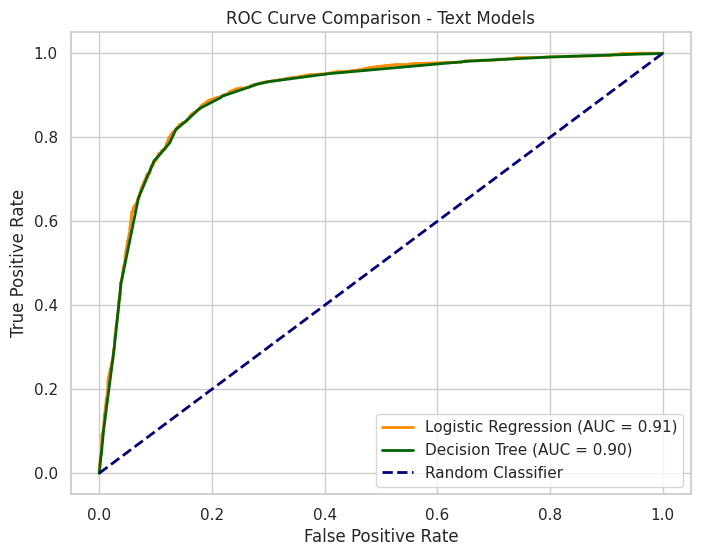

Performance Metrics Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.842503   0.853966  0.842503  0.845193
1        Decision Tree  0.845307   0.846592  0.845307  0.845858


<ipython-input-61-4be2c4d639cc>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette="muted")


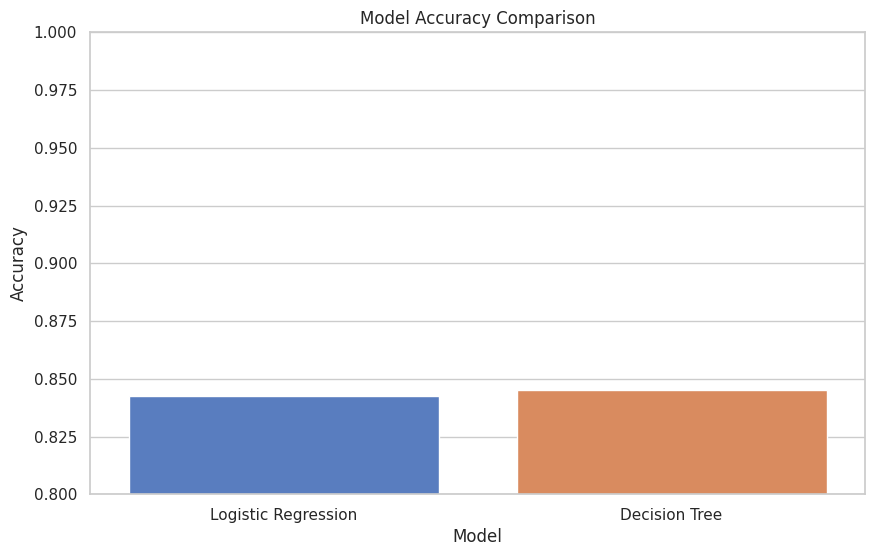

<ipython-input-61-4be2c4d639cc>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=metrics_df, palette="muted")


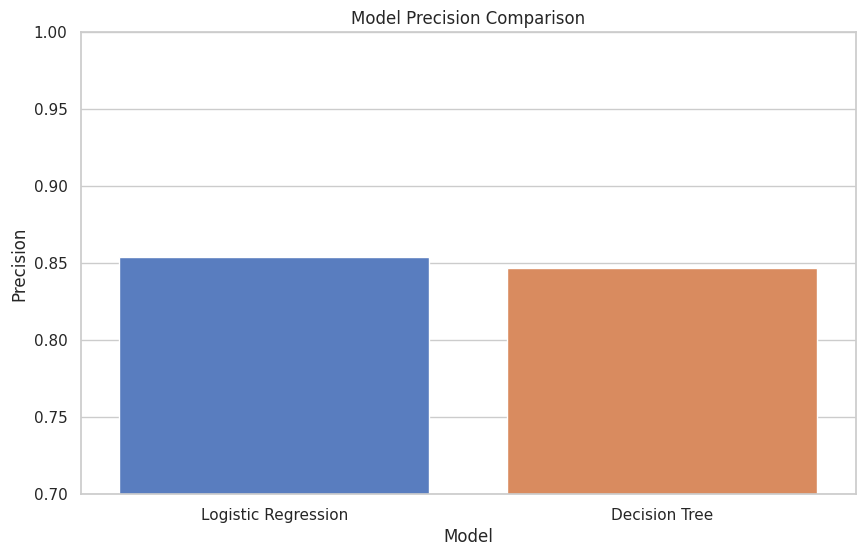

<ipython-input-61-4be2c4d639cc>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=metrics_df, palette="muted")


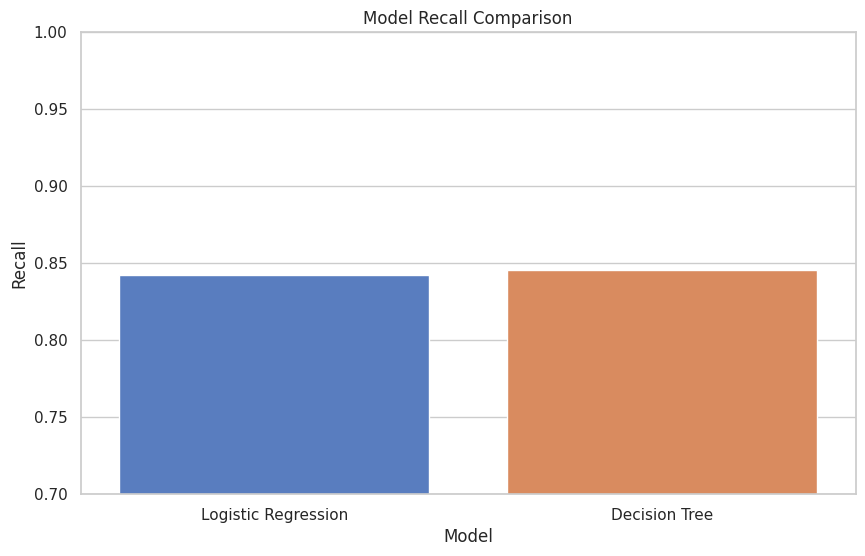

<ipython-input-61-4be2c4d639cc>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette="muted")


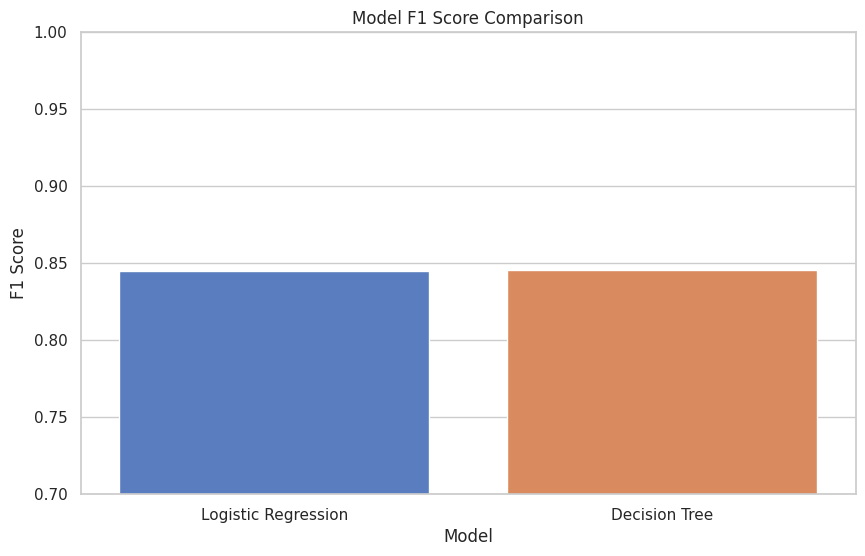

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score

# --- Generate Predictions for Both Models ---
# Predictions
y_pred_lr = grid_lr_text.predict(X_text_test)
y_pred_dt = grid_dt_text.predict(X_text_test)

# Confusion Matrices
cm_lr = confusion_matrix(y_text_test, y_pred_lr)
cm_dt = confusion_matrix(y_text_test, y_pred_dt)

# --- Visualization 1: Side-by-Side Confusion Matrices ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Logistic Regression\nConfusion Matrix")
ax1.set_xlabel("Predicted Label")
ax1.set_ylabel("Actual Label")

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title("Decision Tree\nConfusion Matrix")
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# --- Visualization 2: ROC Curve Comparison ---
# Get predicted probabilities for positive class (assumed class 1)
y_scores_lr = grid_lr_text.predict_proba(X_text_test)[:, 1]
y_scores_dt = grid_dt_text.predict_proba(X_text_test)[:, 1]

# Compute ROC curves and AUCs
fpr_lr, tpr_lr, _ = roc_curve(y_text_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_dt, tpr_dt, _ = roc_curve(y_text_test, y_scores_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color="darkorange", lw=2, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_dt, tpr_dt, color="darkgreen", lw=2, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Text Models")
plt.legend(loc="lower right")
plt.show()

# --- Visualization 3: Bar Chart Comparison of Key Performance Metrics ---
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics for Logistic Regression
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_text_test, y_pred_lr, average='weighted')
accuracy_lr = accuracy_score(y_text_test, y_pred_lr)

# Calculate metrics for Decision Tree
precision_dt, recall_dt, f1_dt, _ = precision_recall_fscore_support(y_text_test, y_pred_dt, average='weighted')
accuracy_dt = accuracy_score(y_text_test, y_pred_dt)

# Create a DataFrame for comparison.
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [accuracy_lr, accuracy_dt],
    'Precision': [precision_lr, precision_dt],
    'Recall': [recall_lr, recall_dt],
    'F1 Score': [f1_lr, f1_dt]
})

print("Performance Metrics Comparison:")
print(metrics_df)

# Plotting the metrics side by side.
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette="muted")
plt.title("Model Accuracy Comparison")
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=metrics_df, palette="muted")
plt.title("Model Precision Comparison")
plt.ylim(0.7, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=metrics_df, palette="muted")
plt.title("Model Recall Comparison")
plt.ylim(0.7, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette="muted")
plt.title("Model F1 Score Comparison")
plt.ylim(0.7, 1.0)
plt.show()


# **4.c Predictive Analytics: Combining Numerical and Text Features**

**Block 1: Combining Features**

We combine the numerical features (stored in `df_scaled`) with the textual features (TF-IDF features in `tfidf_df`) using `pd.concat`. This produces a hybrid feature matrix that includes both types of data for each record.





In [ ]:
# Assuming that:
# - df_scaled contains the cleaned and scaled numerical features.
# - tfidf_df is the DataFrame containing TF-IDF features extracted from the processed review text.

# Let's first ensure that both DataFrames have aligned indices.
df_scaled = df_scaled.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)

# Concatenate the numerical and TF-IDF features to form the hybrid feature matrix.
hybrid_features = pd.concat([df_scaled[numerical_cols], tfidf_df], axis=1)
print("Hybrid feature matrix shape:", hybrid_features.shape)


Hybrid feature matrix shape: (23171, 508)


 **Block 2: Define the Target Variable and Prepare the Hybrid Dataset**

 The target variable is derived by mapping the "Recommended" column to binary values (1 for "yes", 0 for "no"). The hybrid feature matrix (combining numerical and textual data) along with the target variable is then split into training and testing sets using stratification to maintain class balance.

In [ ]:
df['Target'] = df['Recommended'].map({'yes': 1, 'no': 0})
print("Unique Target values after mapping:", df['Target'].unique())
print("Missing target values:", df['Target'].isnull().sum())

# Define X and y for the hybrid model.
X_hybrid = hybrid_features
y_hybrid = df['Target']

# Confirm that the hybrid features have no missing values.
print("\nMissing values in hybrid features:")
print(X_hybrid.isnull().sum())

# Split the hybrid dataset into training and testing subsets.
from sklearn.model_selection import train_test_split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hybrid, y_hybrid, test_size=0.2, random_state=42, stratify=y_hybrid
)
print("\nHybrid Training set shape:", X_train_h.shape)
print("Hybrid Test set shape:", X_test_h.shape)


Unique Target values after mapping: [1 0]
Missing target values: 0

Missing values in hybrid features:
Overall_Rating         0
Seat Comfort           0
Cabin Staff Service    0
Food & Beverages       0
Ground Service         0
                      ..
would                  0
wouldnt                0
wrong                  0
year                   0
yet                    0
Length: 508, dtype: int64

Hybrid Training set shape: (18536, 508)
Hybrid Test set shape: (4635, 508)


###**Block 3: Train and Tune Hybrid Models**
**Block 3.1: Hybrid Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize Logistic Regression.
lr_hybrid = LogisticRegression(solver='liblinear', random_state=42)

# Define parameter grid for regularization strength and penalty.
param_grid_lr_hybrid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Setup GridSearchCV with 5-fold cross-validation.
grid_lr_hybrid = GridSearchCV(
    estimator=lr_hybrid,
    param_grid=param_grid_lr_hybrid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the Logistic Regression model on the hybrid training data.
grid_lr_hybrid.fit(X_train_h, y_train_h)

# Print out best parameters and cross-validation accuracy.
print("\nBest parameters for Hybrid Logistic Regression:", grid_lr_hybrid.best_params_)
print("Best cross-validation accuracy (Hybrid, Logistic Regression):", grid_lr_hybrid.best_score_)

# Evaluate the model on the hybrid test set.
from sklearn.metrics import classification_report, accuracy_score
y_pred_lr_hybrid = grid_lr_hybrid.predict(X_test_h)
print("\nClassification Report (Hybrid Logistic Regression):")
print(classification_report(y_test_h, y_pred_lr_hybrid))
print("Test Accuracy (Hybrid Logistic Regression):", accuracy_score(y_test_h, y_pred_lr_hybrid))



Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for Hybrid Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best cross-validation accuracy (Hybrid, Logistic Regression): 0.9566788567883322

Classification Report (Hybrid Logistic Regression):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3073
           1       0.93      0.94      0.93      1562

    accuracy                           0.96      4635
   macro avg       0.95      0.95      0.95      4635
weighted avg       0.96      0.96      0.96      4635

Test Accuracy (Hybrid Logistic Regression): 0.9553398058252427


**Block 3.2: Hybrid Decision Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier.
dt_hybrid = DecisionTreeClassifier(random_state=42)

# Define parameter grid for maximum depth and minimum samples split.
param_grid_dt_hybrid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Setup GridSearchCV for the Decision Tree model.
grid_dt_hybrid = GridSearchCV(
    estimator=dt_hybrid,
    param_grid=param_grid_dt_hybrid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the Decision Tree model on the hybrid training data.
grid_dt_hybrid.fit(X_train_h, y_train_h)

# Print out best parameters and cross-validation accuracy.
print("\nBest parameters for Hybrid Decision Tree:", grid_dt_hybrid.best_params_)
print("Best cross-validation accuracy (Hybrid, Decision Tree):", grid_dt_hybrid.best_score_)

# Evaluate the Decision Tree model on the hybrid test set.
y_pred_dt_hybrid = grid_dt_hybrid.predict(X_test_h)
print("\nClassification Report (Hybrid Decision Tree):")
print(classification_report(y_test_h, y_pred_dt_hybrid))
print("Test Accuracy (Hybrid Decision Tree):", accuracy_score(y_test_h, y_pred_dt_hybrid))



Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for Hybrid Decision Tree: {'max_depth': 7, 'min_samples_split': 5}
Best cross-validation accuracy (Hybrid, Decision Tree): 0.9612647025700525

Classification Report (Hybrid Decision Tree):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3073
           1       0.95      0.94      0.95      1562

    accuracy                           0.96      4635
   macro avg       0.96      0.96      0.96      4635
weighted avg       0.96      0.96      0.96      4635

Test Accuracy (Hybrid Decision Tree): 0.9633225458468176


### **Block 4: Additional Comparison Visualizations for Hybrid Models**

Hybrid Model Performance Metrics:
                        Model  Accuracy  Precision    Recall  F1 Score
0  Hybrid Logistic Regression  0.955340   0.955377  0.955340  0.955357
1        Hybrid Decision Tree  0.963323   0.963282  0.963323  0.963299


<ipython-input-71-fd94339f315e>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=hybrid_metrics_df, palette='muted')


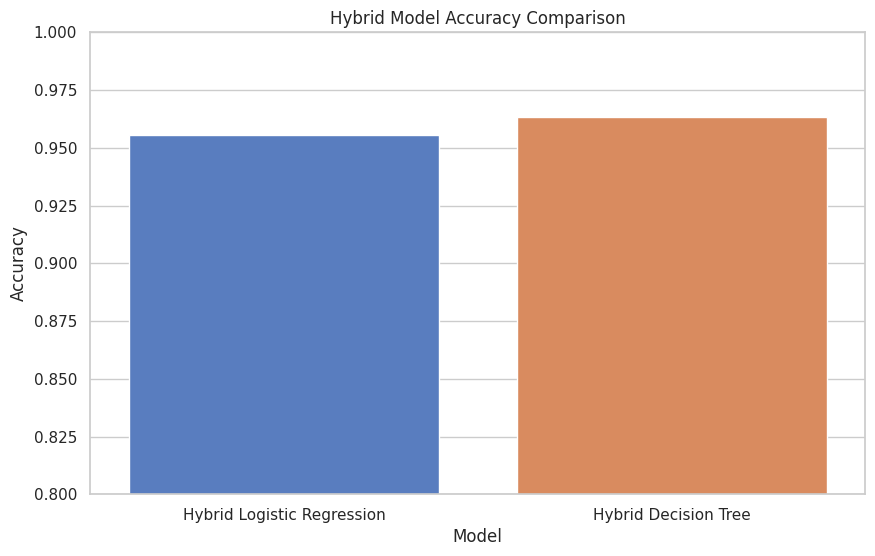

<ipython-input-71-fd94339f315e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=hybrid_metrics_df, palette='muted')


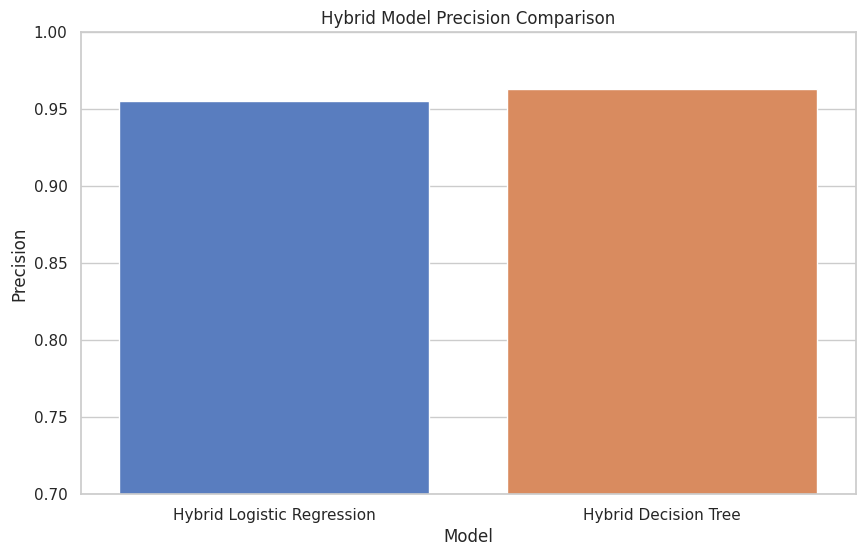

<ipython-input-71-fd94339f315e>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=hybrid_metrics_df, palette='muted')


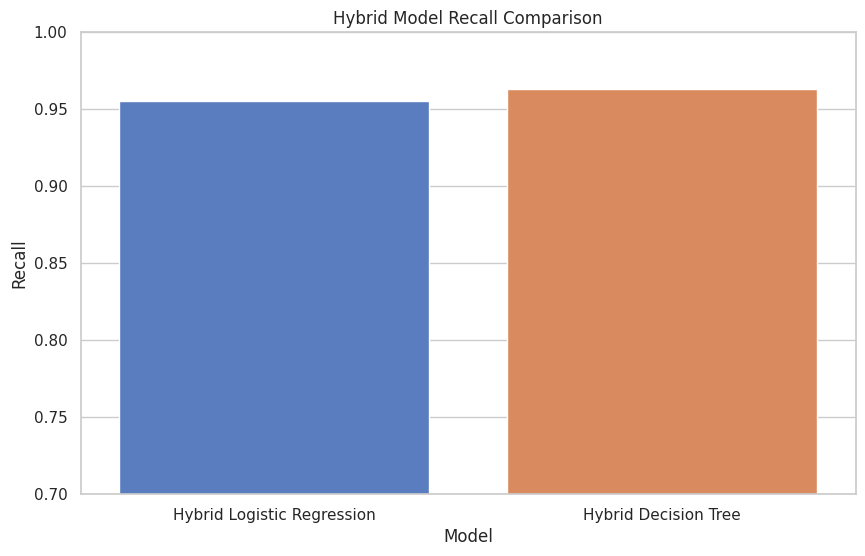

<ipython-input-71-fd94339f315e>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=hybrid_metrics_df, palette='muted')


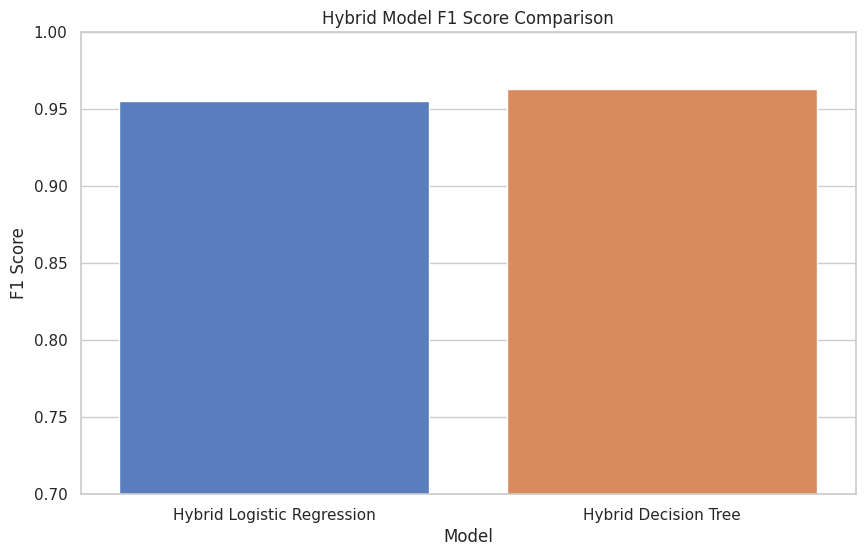

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Calculate performance metrics for the Hybrid Logistic Regression model.
precision_lr_h, recall_lr_h, f1_lr_h, _ = precision_recall_fscore_support(y_test_h, y_pred_lr_hybrid, average='weighted')
accuracy_lr_h = accuracy_score(y_test_h, y_pred_lr_hybrid)

# Calculate performance metrics for the Hybrid Decision Tree model.
precision_dt_h, recall_dt_h, f1_dt_h, _ = precision_recall_fscore_support(y_test_h, y_pred_dt_hybrid, average='weighted')
accuracy_dt_h = accuracy_score(y_test_h, y_pred_dt_hybrid)

# Create a DataFrame to compare these metrics.
hybrid_metrics_df = pd.DataFrame({
    'Model': ['Hybrid Logistic Regression', 'Hybrid Decision Tree'],
    'Accuracy': [accuracy_lr_h, accuracy_dt_h],
    'Precision': [precision_lr_h, precision_dt_h],
    'Recall': [recall_lr_h, recall_dt_h],
    'F1 Score': [f1_lr_h, f1_dt_h]
})

print("Hybrid Model Performance Metrics:")
print(hybrid_metrics_df)

# Plot bar charts to compare Accuracy, Precision, Recall, and F1 Score.
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=hybrid_metrics_df, palette='muted')
plt.title("Hybrid Model Accuracy Comparison")
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=hybrid_metrics_df, palette='muted')
plt.title("Hybrid Model Precision Comparison")
plt.ylim(0.7, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=hybrid_metrics_df, palette='muted')
plt.title("Hybrid Model Recall Comparison")
plt.ylim(0.7, 1.0)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=hybrid_metrics_df, palette='muted')
plt.title("Hybrid Model F1 Score Comparison")
plt.ylim(0.7, 1.0)
plt.show()
